# Environment Setup

In [2]:
%pip install missingno matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from IPython.core.interactiveshell import InteractiveShell
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
# display scientific notation as a float
pd.set_option("display.float_format", lambda x: "%.3f" % x)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params, palette="Set2")

encodings = {}


In [25]:
import data_cleaning_lib as lib


# Part III: Data Cleaning
---

## D1: Cleaning Findings

In [4]:
filename = "./src/Medical Data/medical_raw_data.csv"
df = pd.read_csv(filename)
treated_df = df.copy()


### Duplicate Treatment

In [5]:
treated_df = treated_df.drop_duplicates(subset=["Customer_id", "Interaction", "UID"])
assert treated_df.duplicated(subset=["Customer_id", "Interaction", "UID"]).sum() == 0


### Missing Value Treatment

In [6]:
null_df = treated_df.isnull().sum()
null_counts_df = null_df[null_df > 0].sort_values(ascending=False)

# store the list of column names with missing values
missing_cols = null_counts_df.index

null_counts_df


Children        2588
Soft_drink      2467
Income          2464
Age             2414
Initial_days    1056
Anxiety          984
Overweight       982
dtype: int64

#### Children Imputation Comps

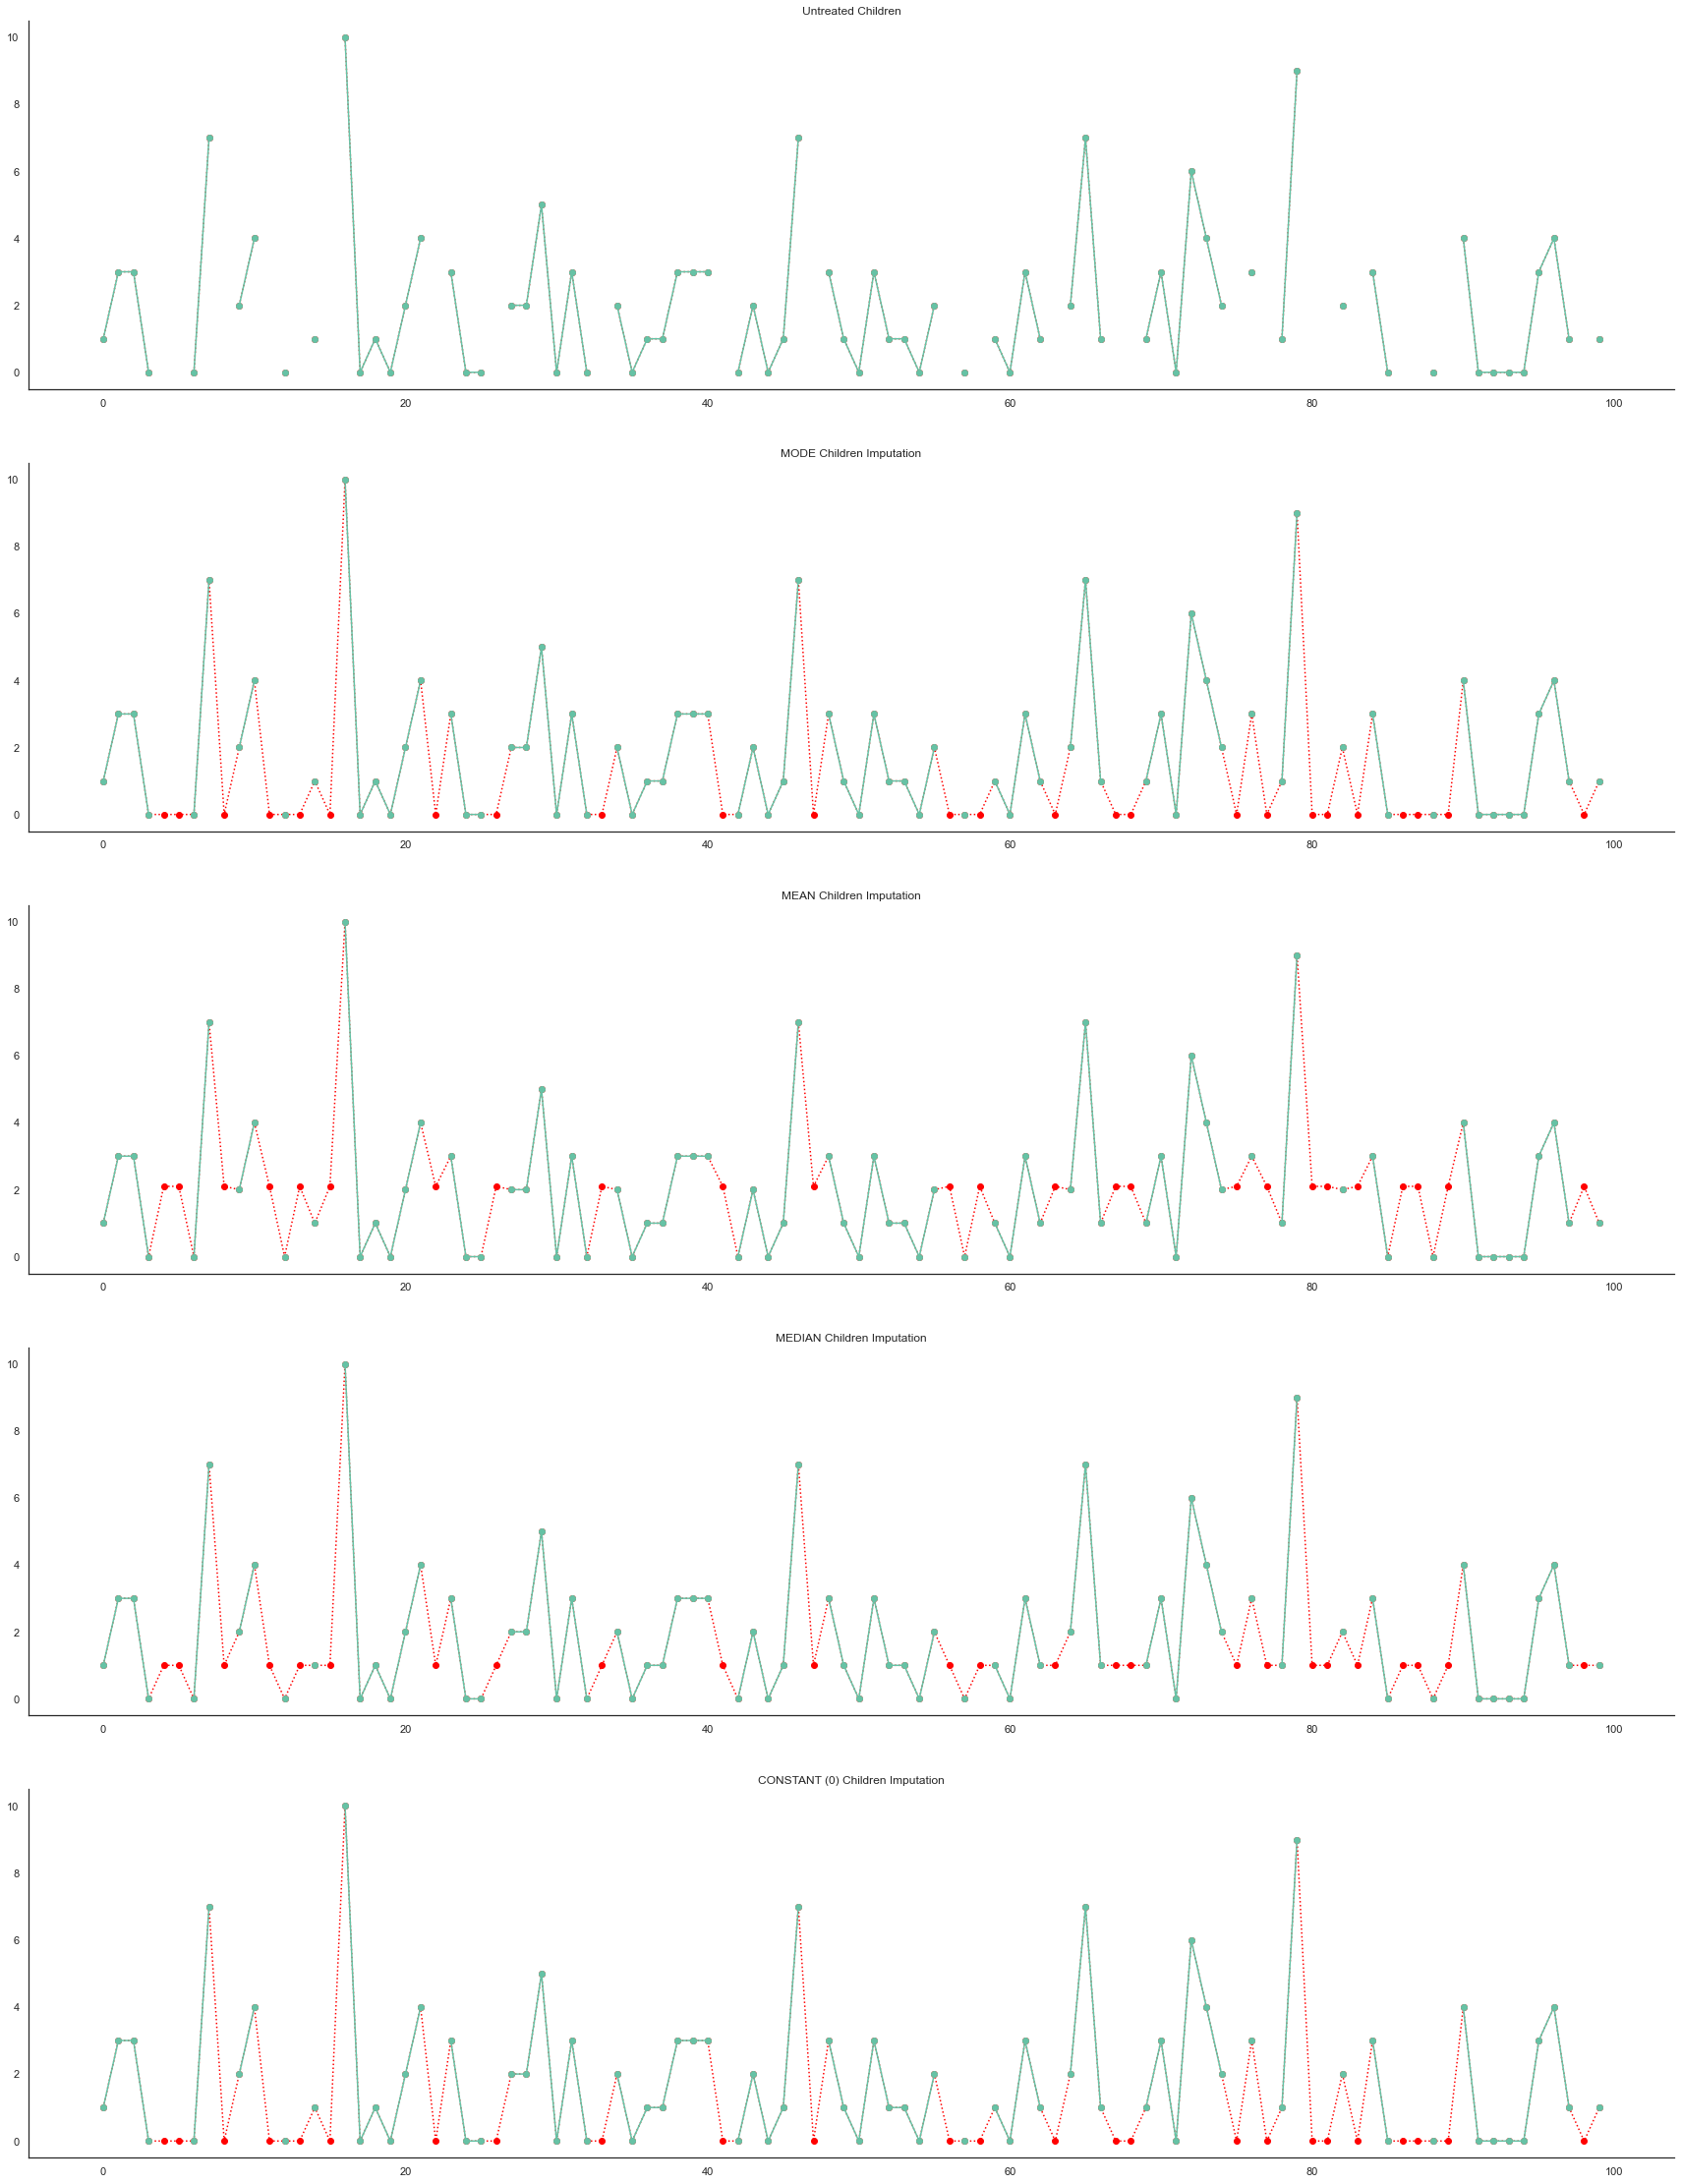

In [7]:
n = 100
col = "Children"
imp_df = df[col].head(n)

imputations = {
    f"Untreated {col}": imp_df,
    # f"BFILL (next observed value) {col} Imputation": imp_df.fillna(method="bfill"),
    # f"FFILL (last observed value) {col} Imputation": imp_df.fillna(method="ffill"),
    f"MODE {col} Imputation": imp_df.fillna(df[col].mode()[0]),
    f"MEAN {col} Imputation": imp_df.fillna(df[col].mean()),
    f"MEDIAN {col} Imputation": imp_df.fillna(df[col].median()),
    f"CONSTANT (0) {col} Imputation": imp_df.fillna(0),
    # f"Nearest Observable Value Imputation": imp_df.interpolate(method="nearest"),
    # f"Quadratic Imputation": imp_df.interpolate(method="quadratic"),
    # f"Linear Imputation": imp_df.interpolate(method="linear"),
}

fig, axes = plt.subplots(len(imputations), 1, figsize=(30, 40))

for ax, (k, v) in zip(axes, imputations.items()):
    _ = v.plot(title=k, color="red", marker="o", linestyle="dotted", ax=ax)
    _ = df[col].head(n).plot(marker="o", ax=ax)


#### Age Imputation Comps

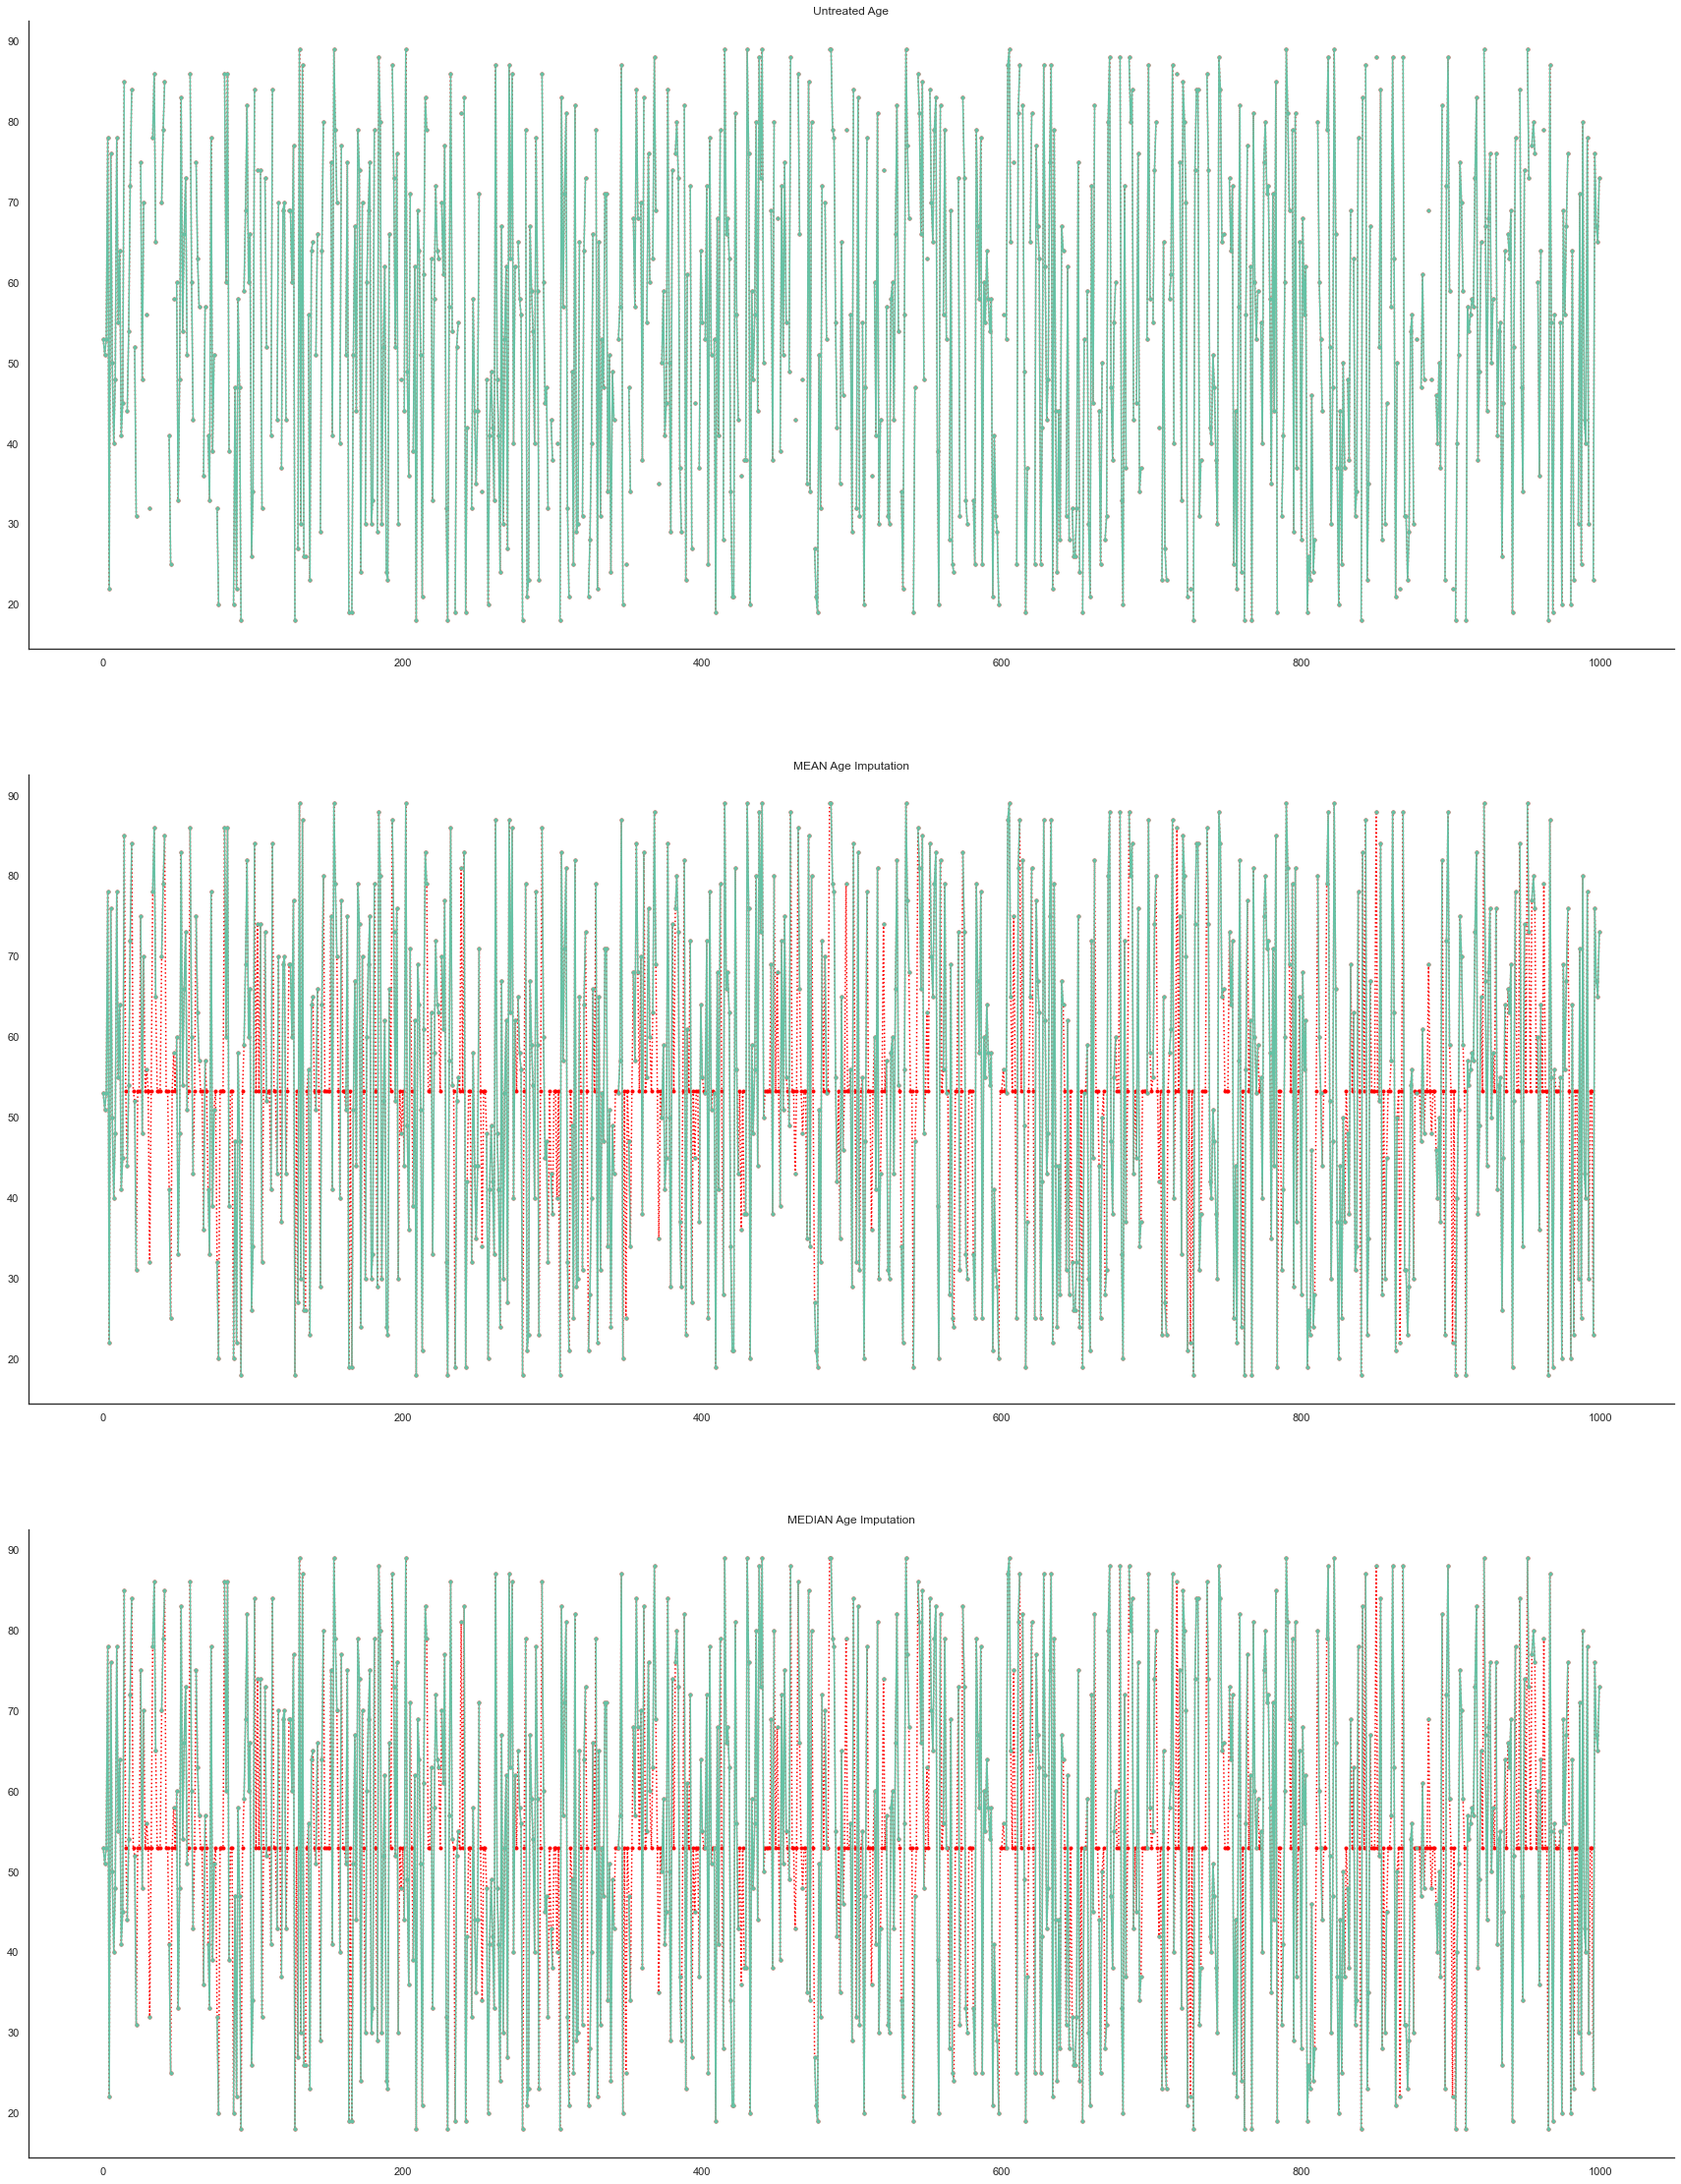

In [8]:
n = 1000
col = "Age"
imp_df = df[col].head(n)

imputations = {
    f"Untreated {col}": imp_df,
    f"MEAN {col} Imputation": imp_df.fillna(df[col].mean()),
    f"MEDIAN {col} Imputation": imp_df.fillna(df[col].median()),
}

fig, axes = plt.subplots(len(imputations), 1, figsize=(30, 40))

for ax, (k, v) in zip(axes, imputations.items()):
    _ = v.plot(title=k, color="red", marker=".", linestyle="dotted", ax=ax)
    _ = df[col].head(n).plot(marker=".", ax=ax)


#### Initial_days Imputation Comps

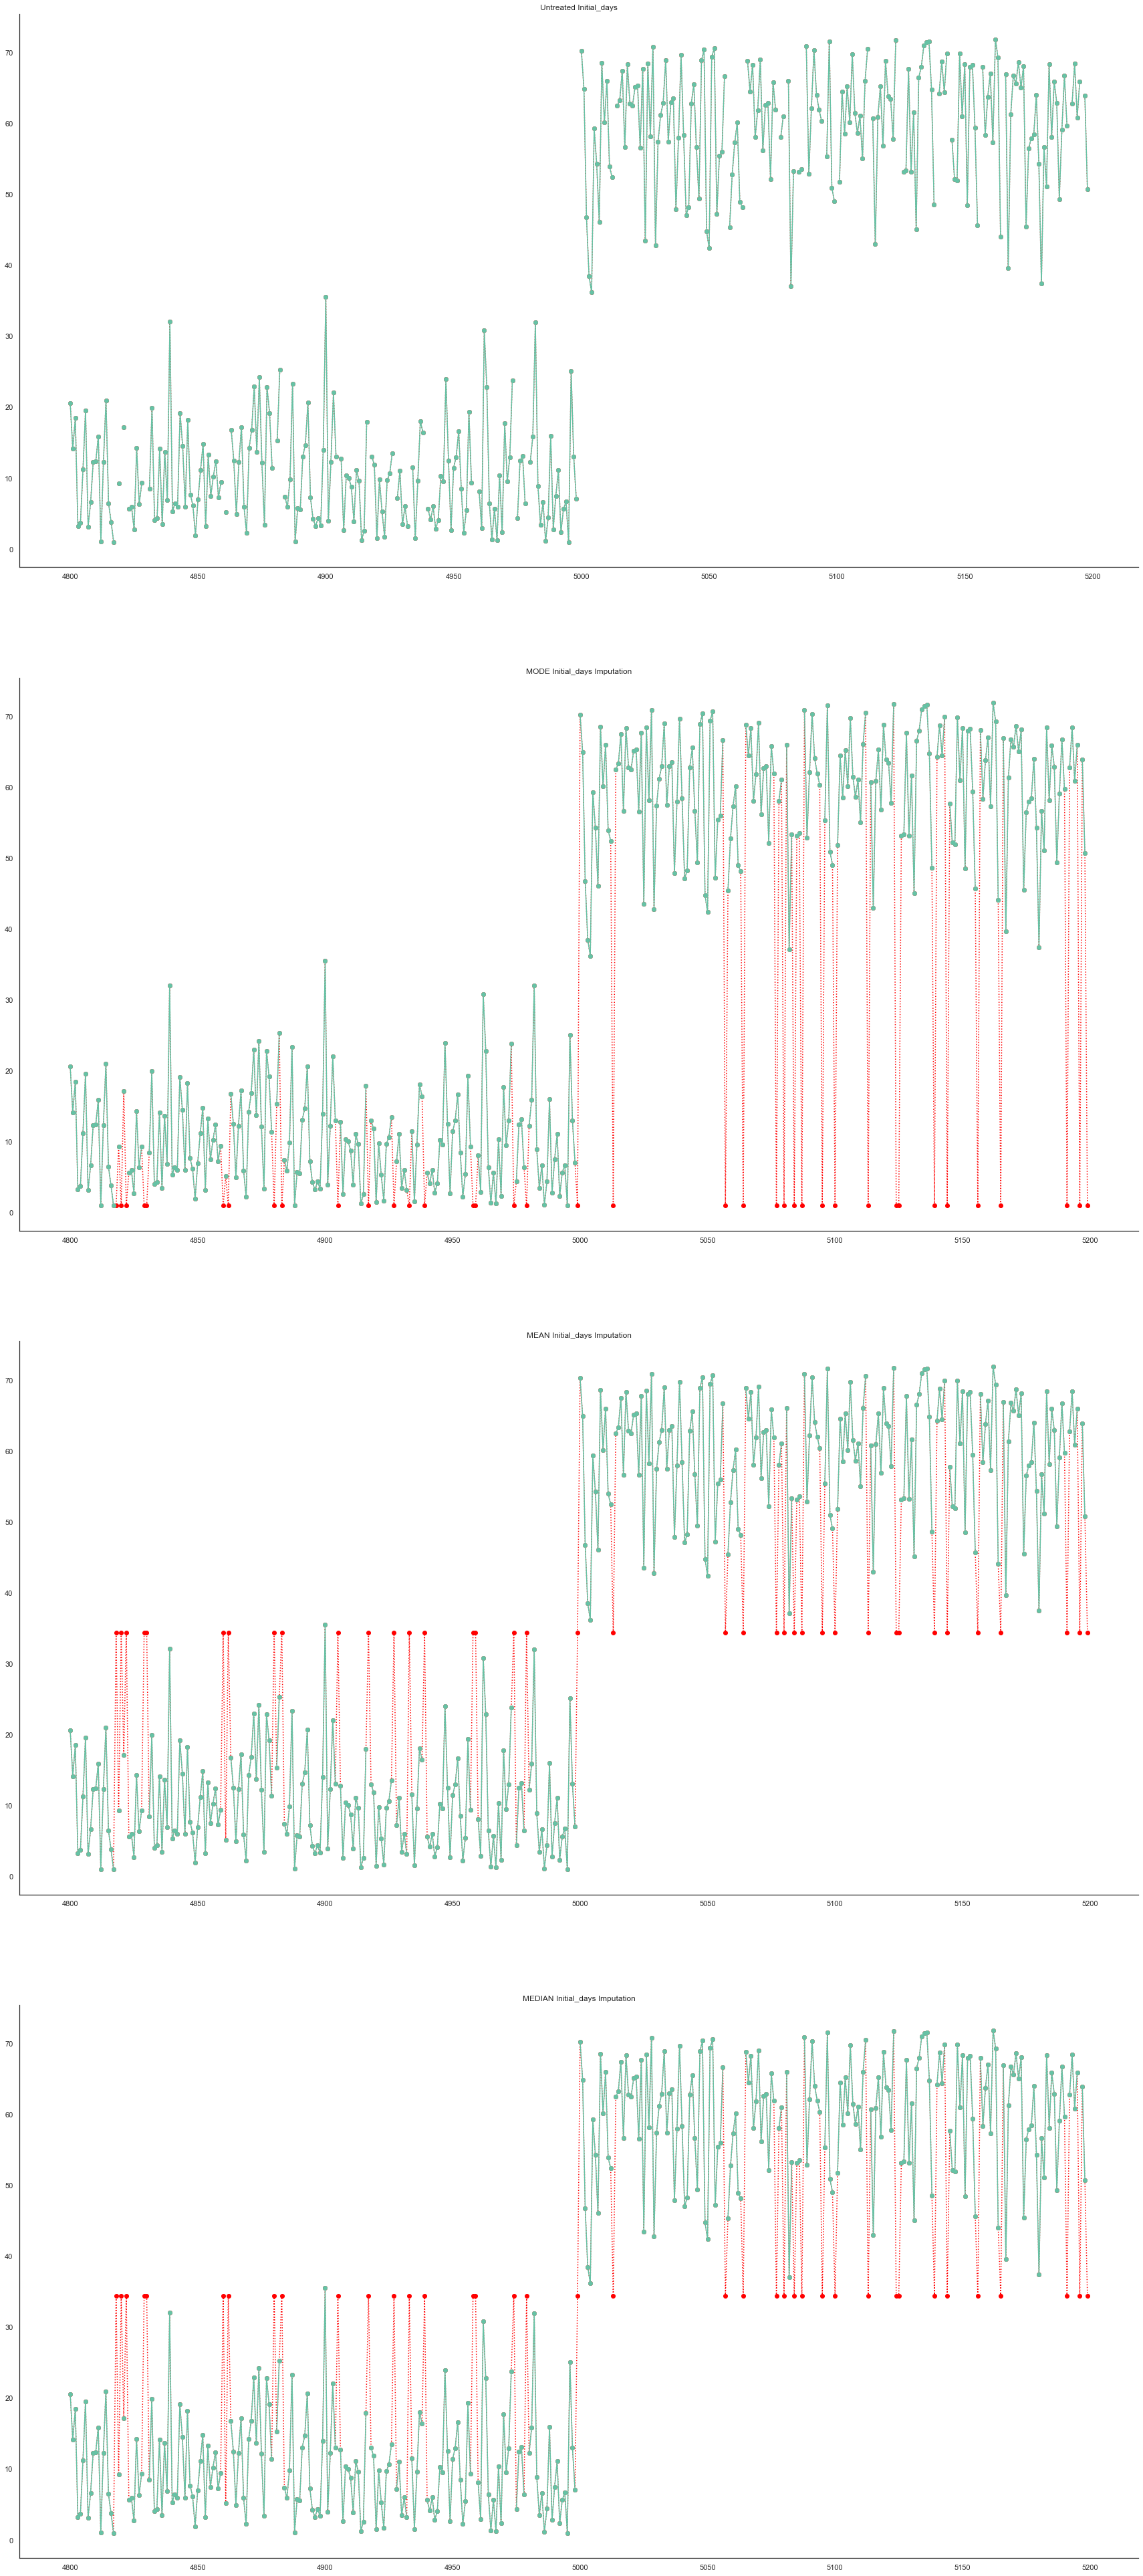

In [9]:
col = "Initial_days"
rows = range(4800, 5200)
imp_df = df[col].loc[rows]

imputations = {
    f"Untreated {col}": imp_df,
    f"MODE {col} Imputation": imp_df.fillna(df[col].mode()[0]),
    f"MEAN {col} Imputation": imp_df.fillna(df[col].mean()),
    f"MEDIAN {col} Imputation": imp_df.fillna(df[col].median()),
}

fig, axes = plt.subplots(len(imputations), 1, figsize=(30, 70))

for ax, (k, v) in zip(axes, imputations.items()):
    _ = v.plot(title=k, color="red", marker="o", linestyle="dotted", ax=ax)
    _ = df[col].loc[rows].plot(marker="o", ax=ax)


#### Imputations

In [10]:
# uniform and multimodal distributions (mean)
for col in ["Age", "Initial_days"]:
    treated_df[col] = df[col].fillna(df[col].mean())

# skewed distributions (median)
for col in ["Income"]:
    treated_df[col] = df[col].fillna(df[col].median())

# binomial distributions (mode)
for col in ["Anxiety", "Overweight"]:
    treated_df[col] = df[col].fillna(df[col].mode()[0])

# Use Constant Value
treated_df.loc[treated_df["Soft_drink"].isnull(), ["Soft_drink"]] = "No"
treated_df.loc[treated_df["Children"].isnull(), ["Children"]] = 0


### Verify Missing Value Imputation

In [11]:
nan_df = treated_df.isnull().sum()

if nan_df.sum() != 0:
    raise AssertionError(f"NaN values still exist in the dataset\n{nan_df[nan_df > 0]}")
else:
    print("No remaining missing values")


No remaining missing values


### Compare Treated and Untreated Data Summaries

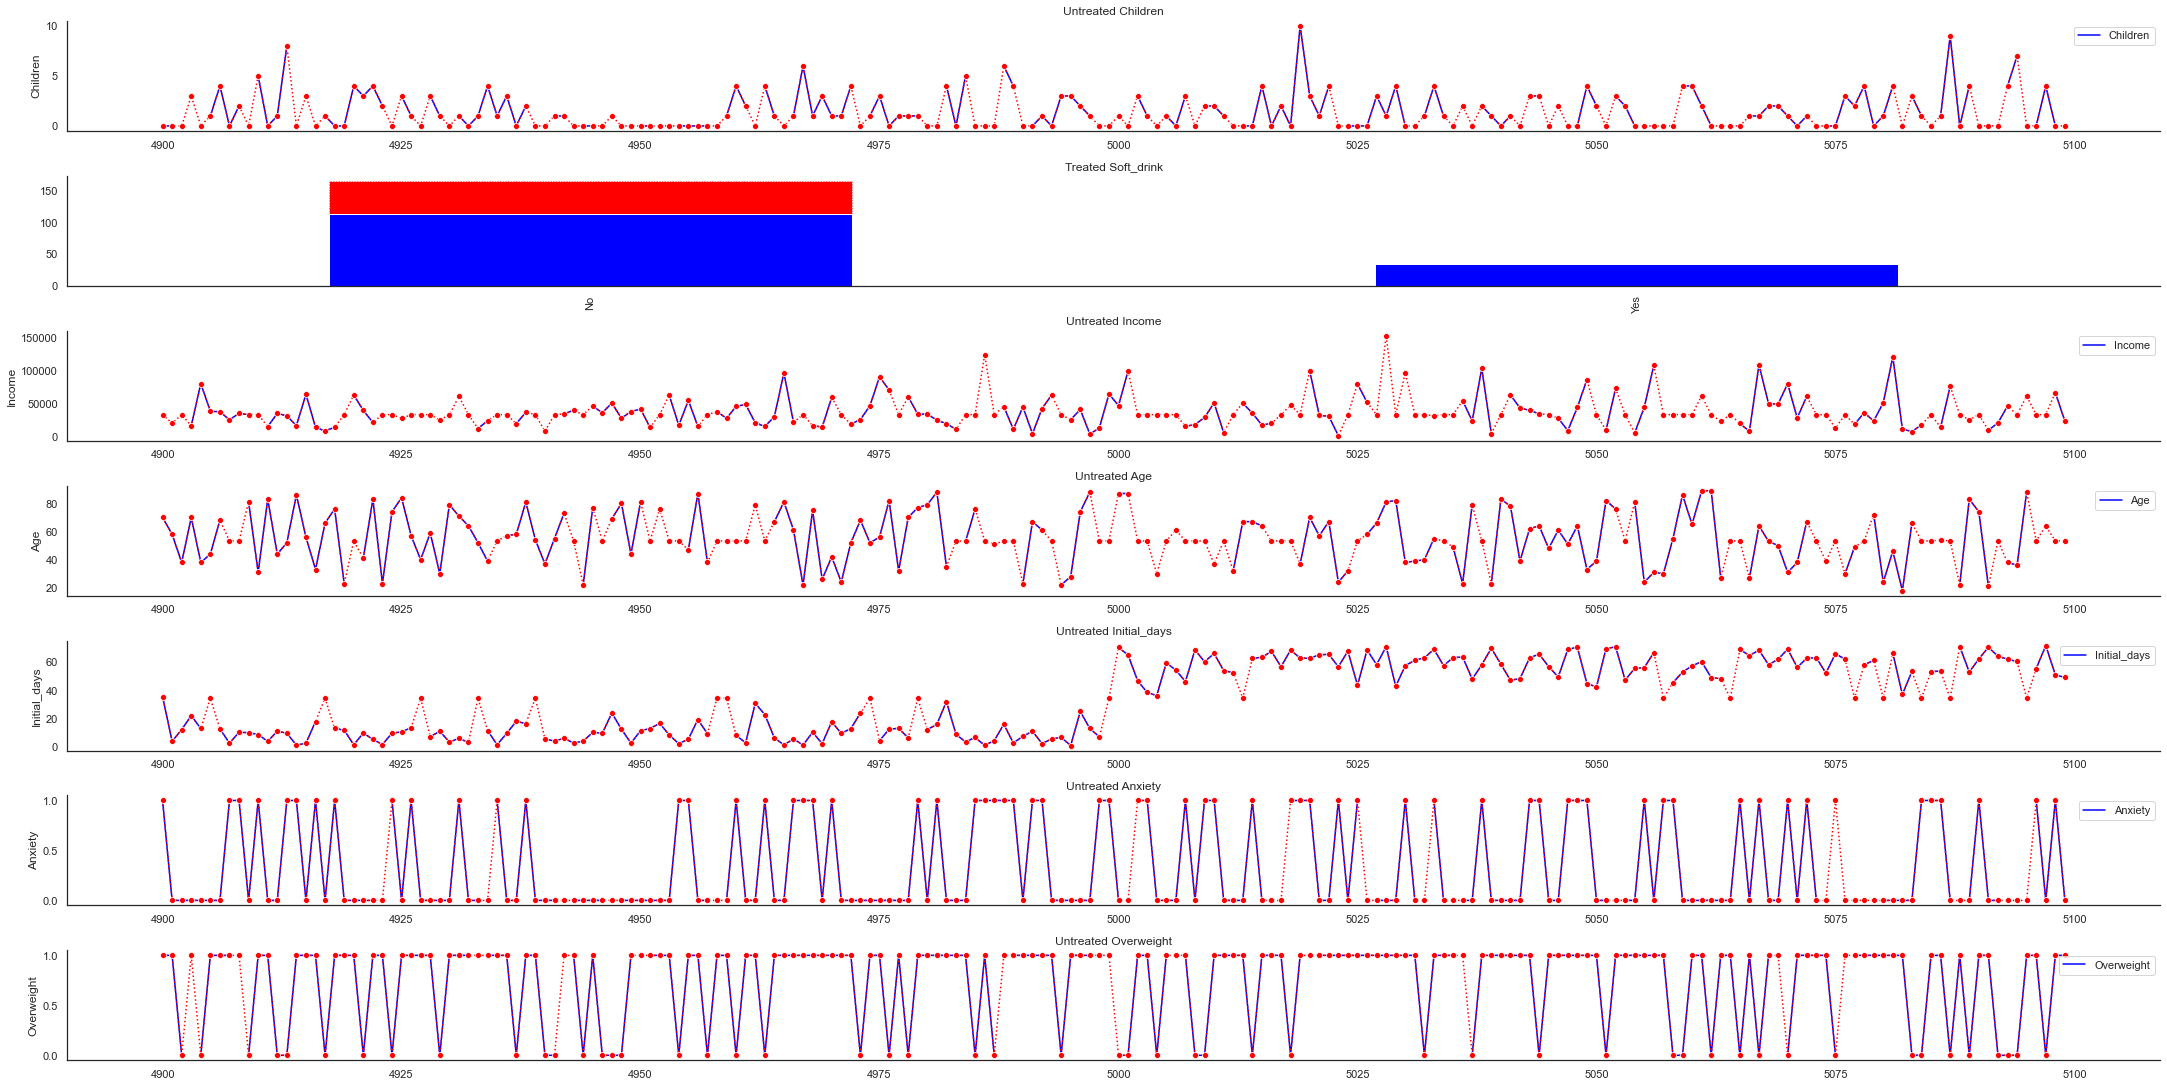

In [12]:
fig, axes = plt.subplots(len(missing_cols), 1, figsize=(30, 15))
rows = range(4900, 5100)

for ax, col in zip(axes, missing_cols):
    try:
        _ = data = df[col].loc[rows].plot(title=f"Untreated {col}", color="blue", ax=ax)
        _ = sns.lineplot(
            data=treated_df[col].loc[rows],
            color="red",
            marker="o",
            linestyle="dotted",
            ax=ax,
        )
    except TypeError:
        # display non-numeric data in a bar chart
        _ = (
            treated_df[col]
            .loc[rows]
            .value_counts()
            .plot(
                title=f"Treated {col}",
                kind="bar",
                color="red",
                linestyle="dotted",
                ax=ax,
            )
        )
        _ = df[col].loc[rows].value_counts().plot(color="blue", kind="bar", ax=ax)
        pass

    # compare Treated and Untreated data descriptions
    pd.DataFrame(
        {
            f"Untreated {col}": df[col].describe(),
            f"Treated {col}": treated_df[col].describe(),
        }
    )

fig.tight_layout(pad=0.3)


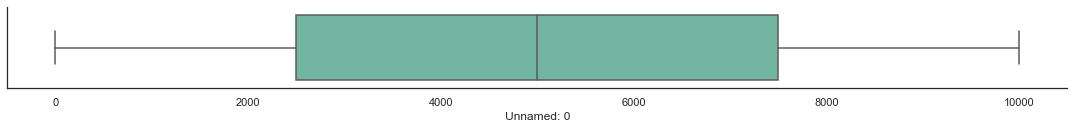

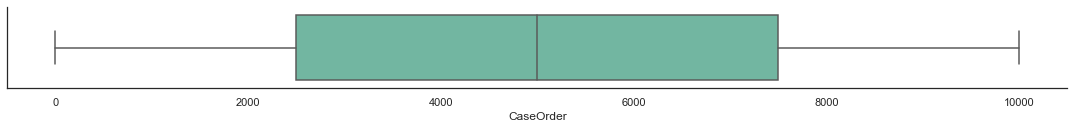

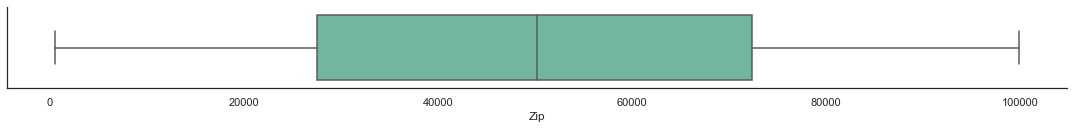

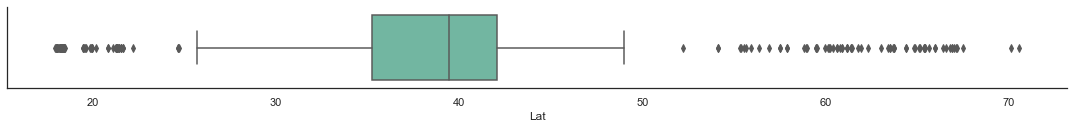

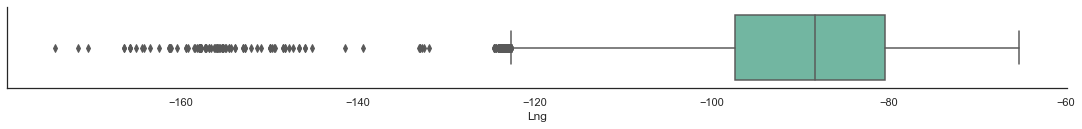

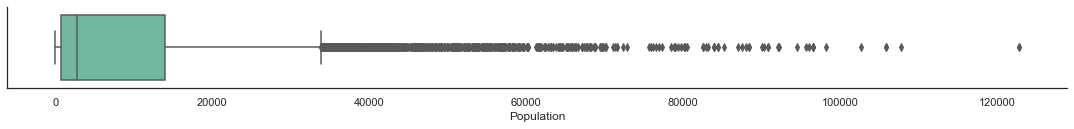

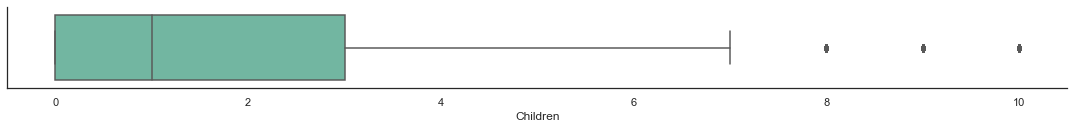

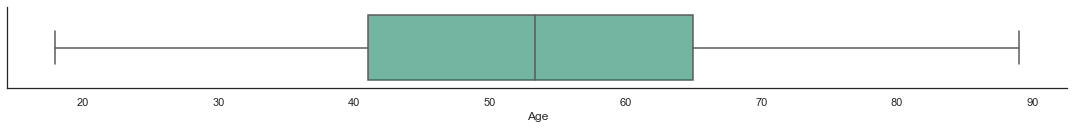

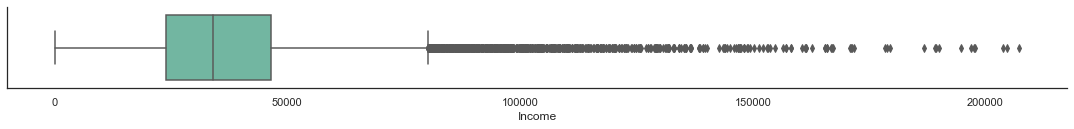

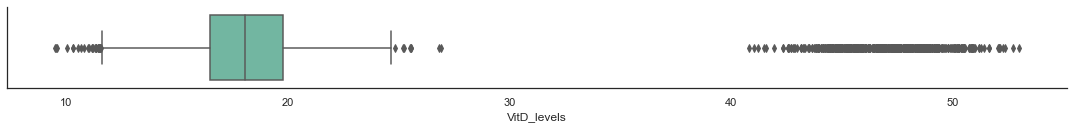

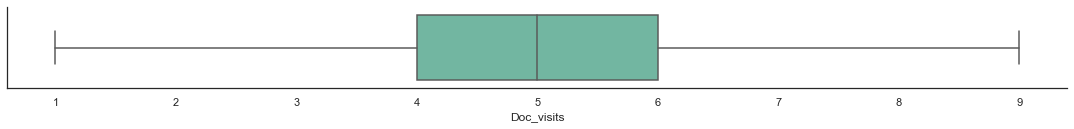

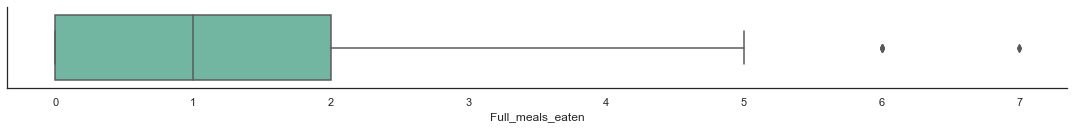

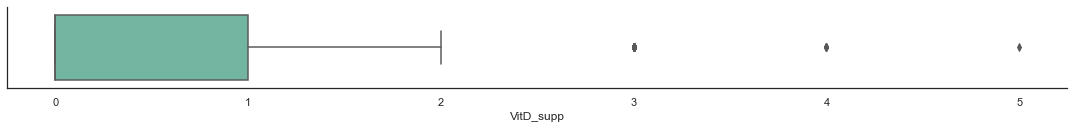

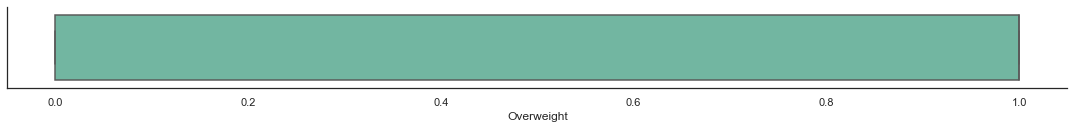

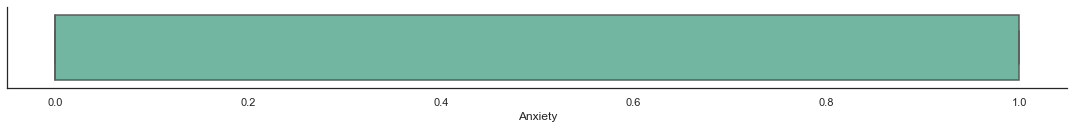

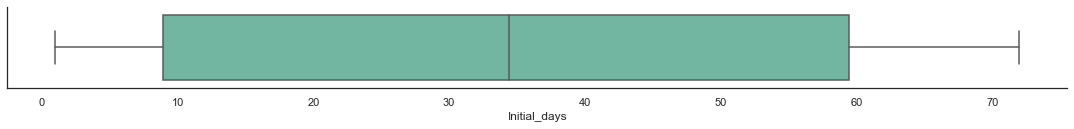

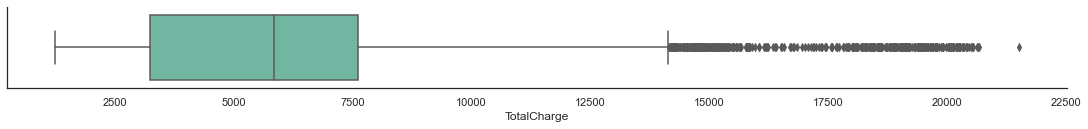

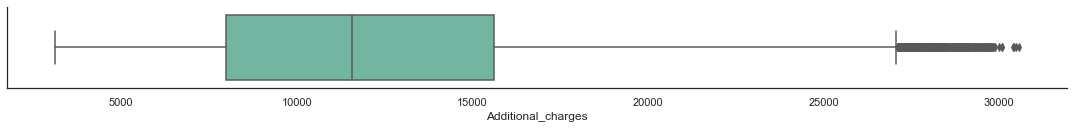

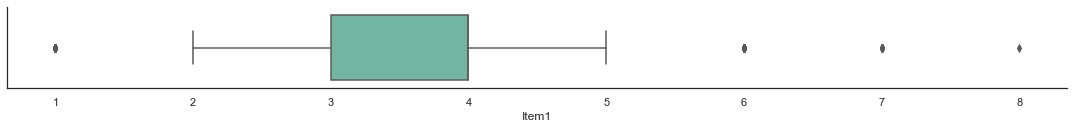

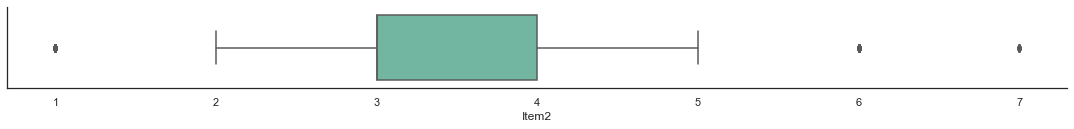

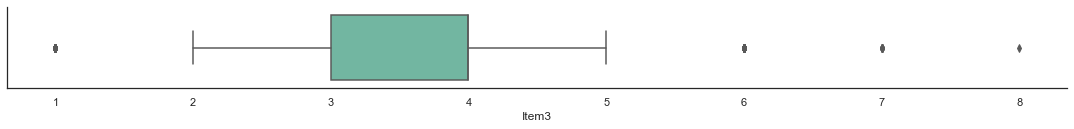

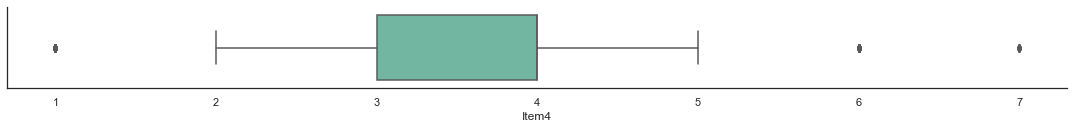

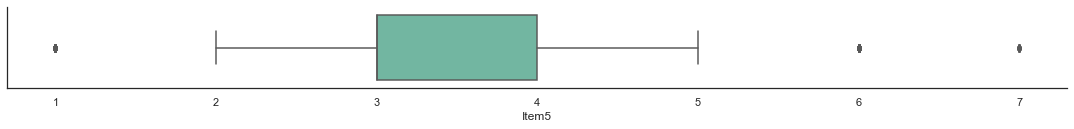

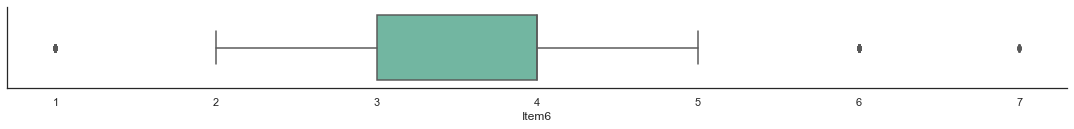

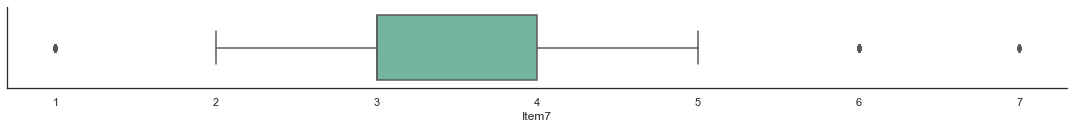

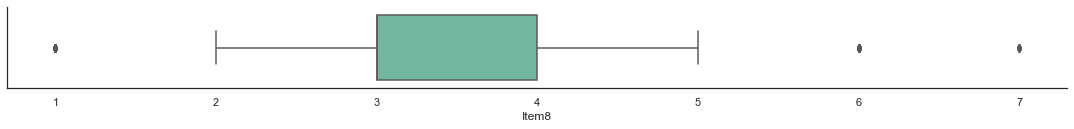

In [13]:
lib.create_boxplots(treated_df)


### Outlier Treatment

In [14]:
# numerical columns with notable outliers outliers are allowed on columns not listed here
z_score_cols = [
    "Children",
    "VitD_levels",
    "Full_meals_eaten",
    "VitD_supp",
    "TotalCharge",
    "Additional_charges",
]

treated_df["Children"].value_counts()


0.000     4468
1.000     1858
3.000     1113
2.000     1094
4.000      739
8.000      157
7.000      154
6.000      145
5.000      126
9.000       83
10.000      63
Name: Children, dtype: int64

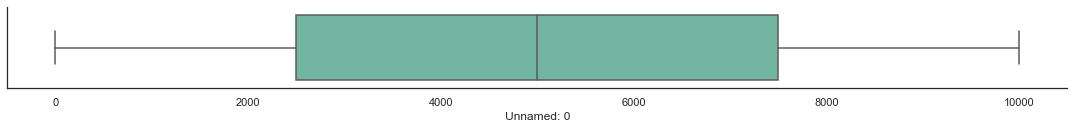

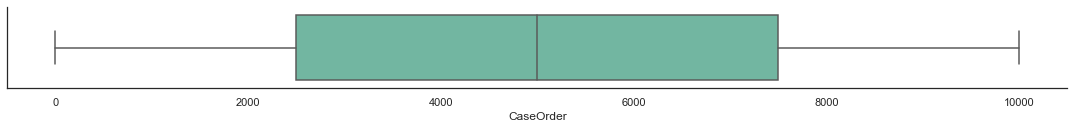

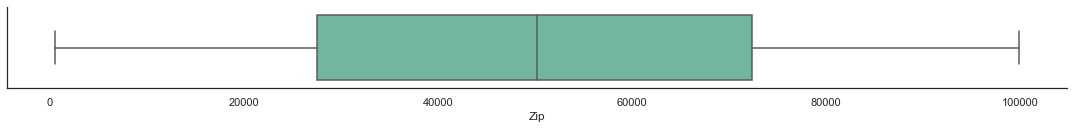

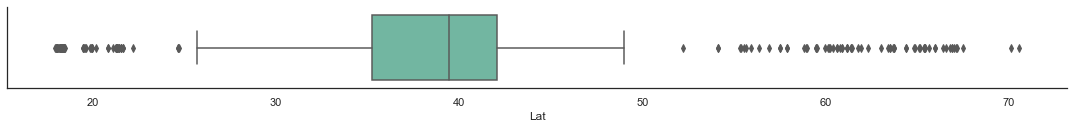

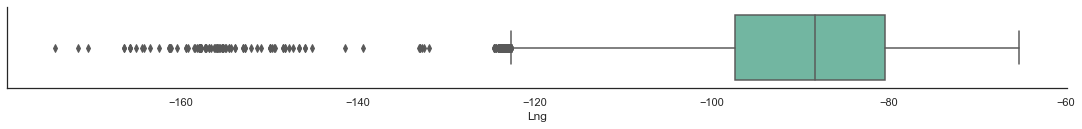

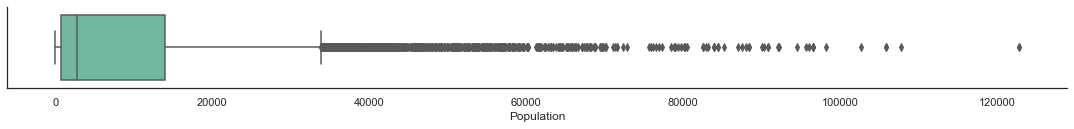

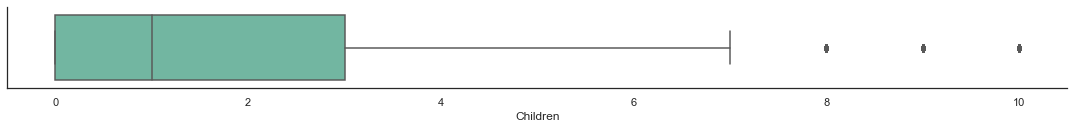

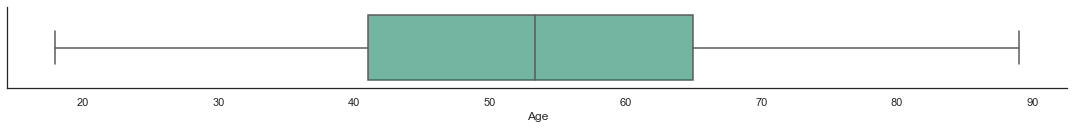

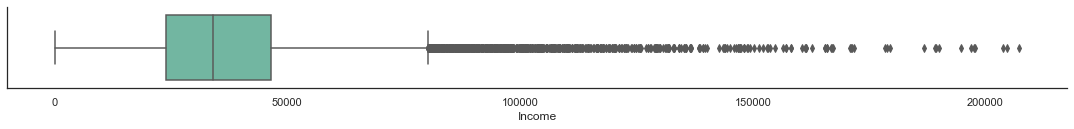

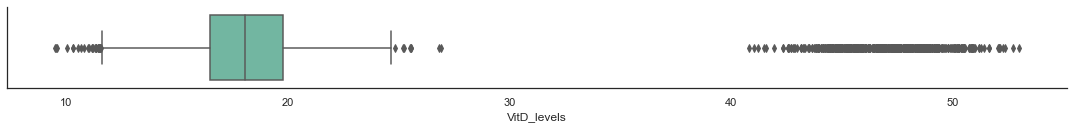

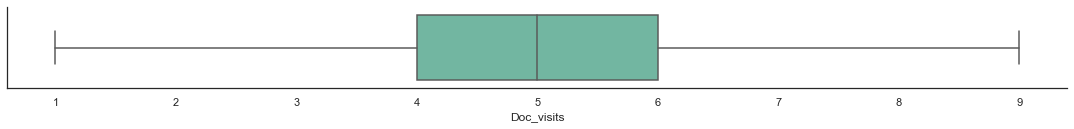

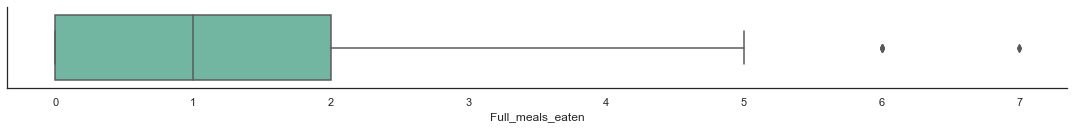

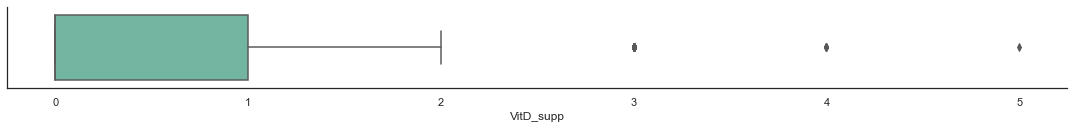

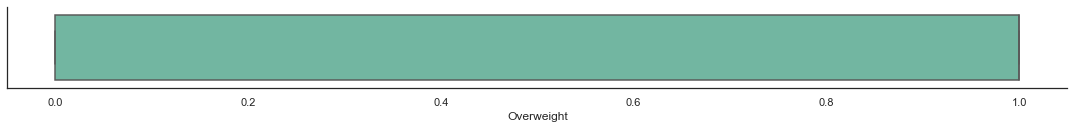

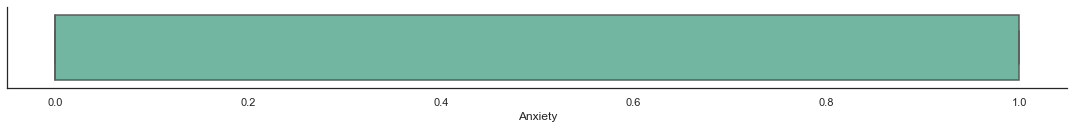

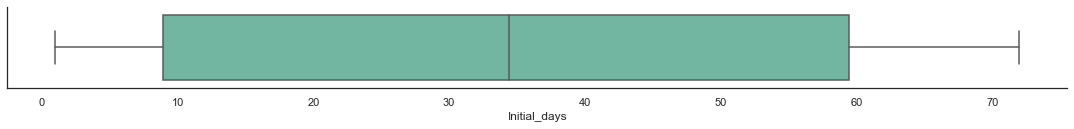

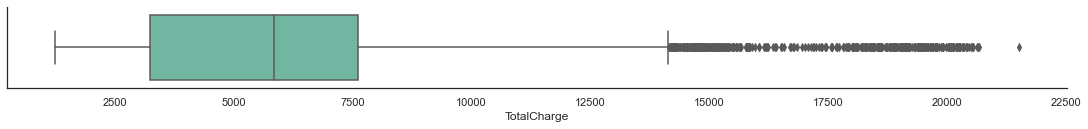

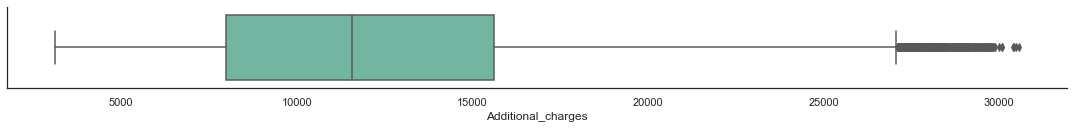

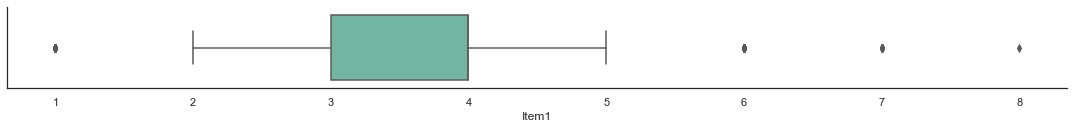

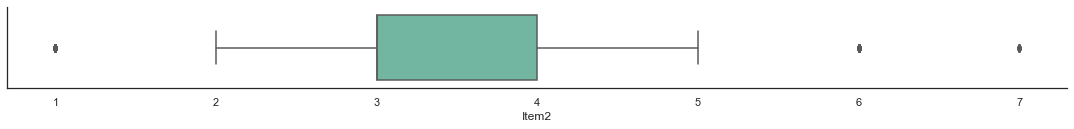

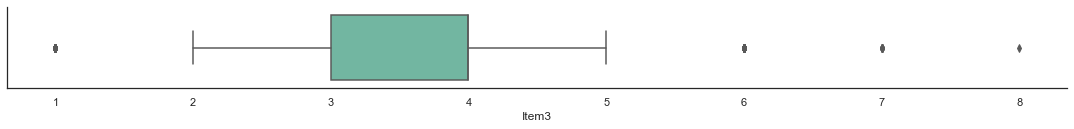

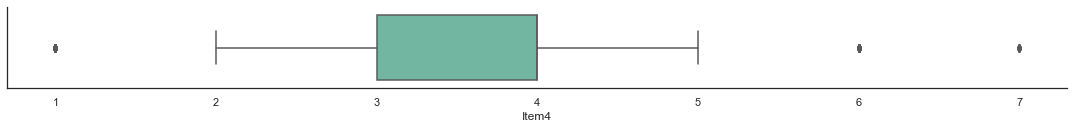

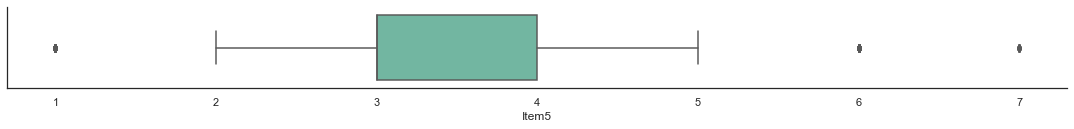

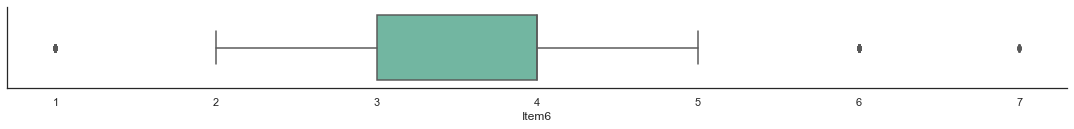

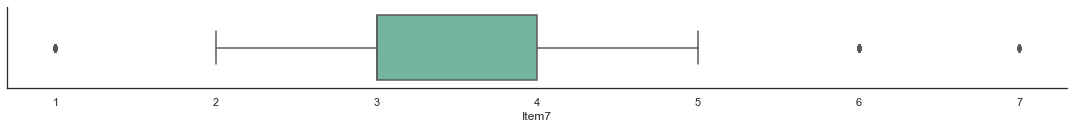

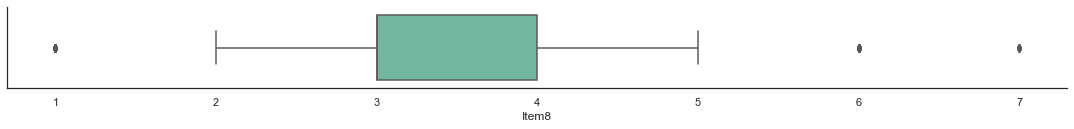

In [15]:
lib.create_boxplots(treated_df)


#### VitD_levels Outlier Exploration

In [16]:
# pd.set_option('display.max_rows', None)
# determine what correlation exists between Gender and VitD_levels
pd.DataFrame(
    treated_df[treated_df["Gender"] == "Prefer not to answer"][
        ["VitD_levels", "Gender", "Age"]
    ]
    .round()
    .sort_values(ascending=False, by=["VitD_levels", "Age"])
).head(10)

# determine what the average VitD_levels are by Gender and Age
treated_df[["VitD_levels", "Gender", "Age"]].round().groupby(["Gender", "Age"]).agg(
    {"VitD_levels": "mean"}
).sort_values("VitD_levels")

# determine what correlation exists between Gender and VitD_levels
vitd_df = df.copy()
vitd_df["Gender"] = df["Gender"].map(
    {"Prefer not to answer": 0, "Male": 1, "Female": 2}
)
vitd_df.corr()["VitD_levels"].sort_values(ascending=False)


VitD_levels           1.000
TotalCharge           0.728
Age                   0.020
Additional_charges    0.016
Anxiety               0.014
Item4                 0.013
VitD_supp             0.010
Full_meals_eaten      0.009
Item6                 0.008
Item8                 0.004
Population            0.003
Item7                 0.002
Doc_visits            0.001
Income                0.000
Lng                  -0.000
Initial_days         -0.001
Unnamed: 0           -0.002
CaseOrder            -0.002
Children             -0.002
Item1                -0.004
Lat                  -0.004
Overweight           -0.008
Zip                  -0.008
Gender               -0.011
Item5                -0.012
Item3                -0.013
Item2                -0.018
Name: VitD_levels, dtype: float64

#### VitD_levels Outlier Treatment

In [17]:
# no treatment - retaining existing values


#### Children Outlier Exploration

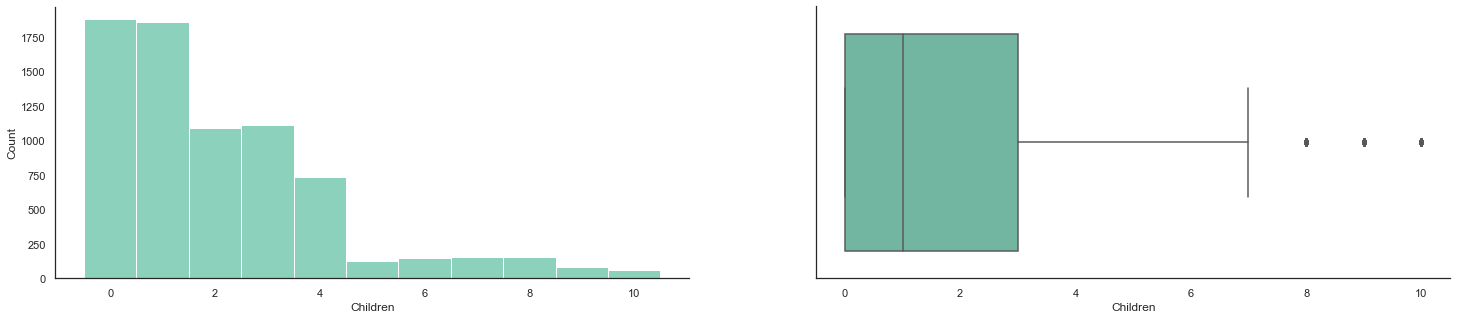

In [18]:
lib.create_hist_and_boxplots(df, "Children")


#### Children Outlier Treatment

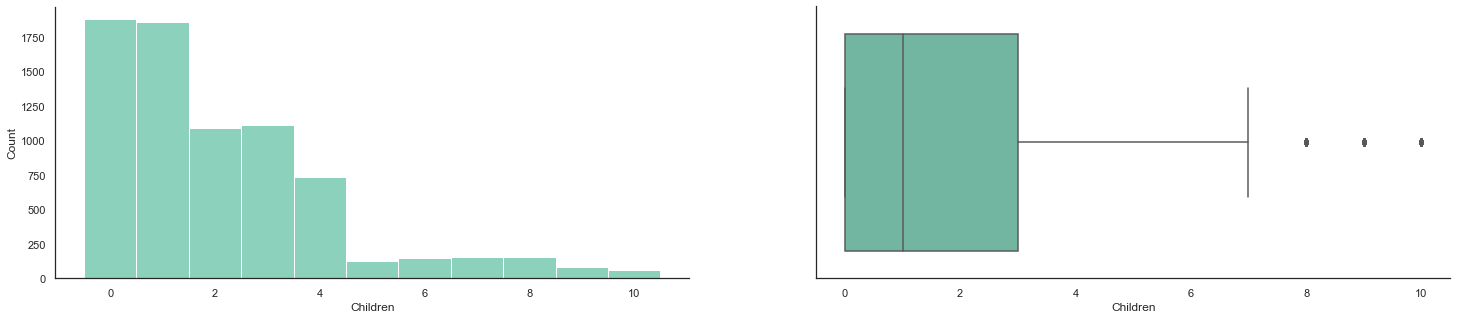

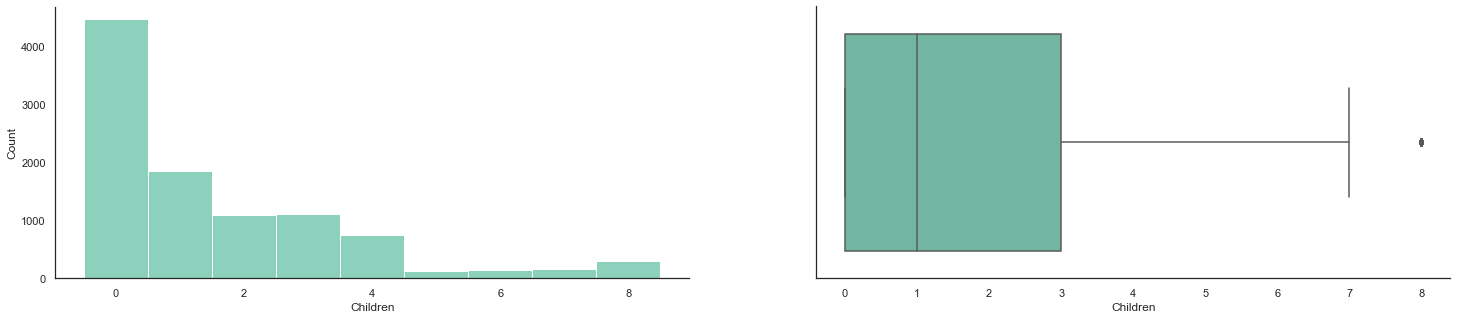

In [19]:
col = "Children"

children_z_df = abs(stats.zscore(df[col], nan_policy="omit"))
pd.DataFrame(df[children_z_df > 3][col].value_counts())

treated_df[col] = treated_df[col].astype("int")

# store maximum number of children that is a nonoutlier
max_num_children = df[children_z_df < 3][col].max()

# set the Children outliers to the max nonoutlier
treated_df.loc[treated_df[col] > max_num_children, col] = max_num_children

assert treated_df[col].max() == max_num_children

lib.create_hist_and_boxplots(df, col)
lib.create_hist_and_boxplots(treated_df, col)


#### Full_meals_eaten Outlier Exploration

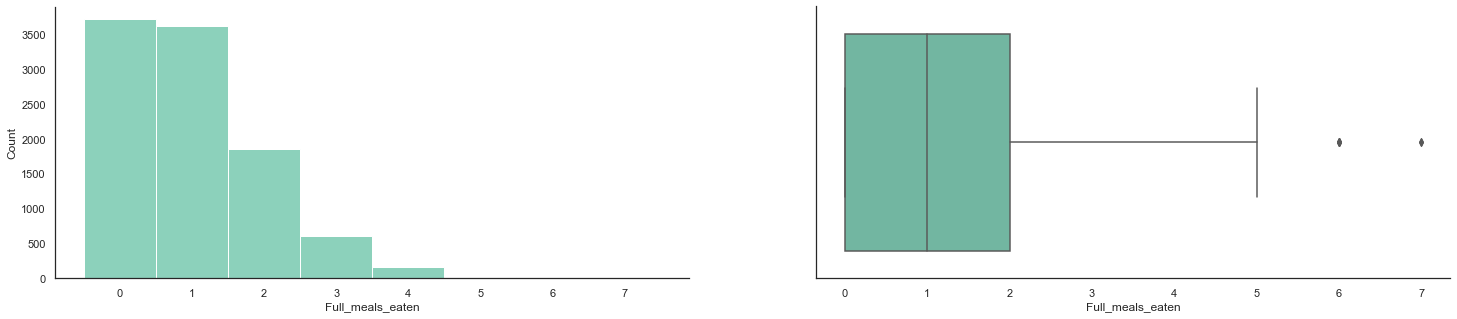

In [20]:
lib.create_hist_and_boxplots(df, "Full_meals_eaten")


#### Full_meals_eaten Outlier Treatment

In [21]:
col = "Full_meals_eaten"

meals_z_df = abs(stats.zscore(df[col], nan_policy="omit"))
pd.DataFrame(df[meals_z_df > 3][col].value_counts())

treated_df[col] = treated_df[col].astype("int")

# store maximum number of children that is a nonoutlier
max_num_meals = df[children_z_df < 3][col].max()
med_num_meals = df[col].median()

# set the meals eaten outliers to the median value
treated_df.loc[meals_z_df > 3, col] = med_num_meals

assert treated_df[col].max() <= max_num_meals


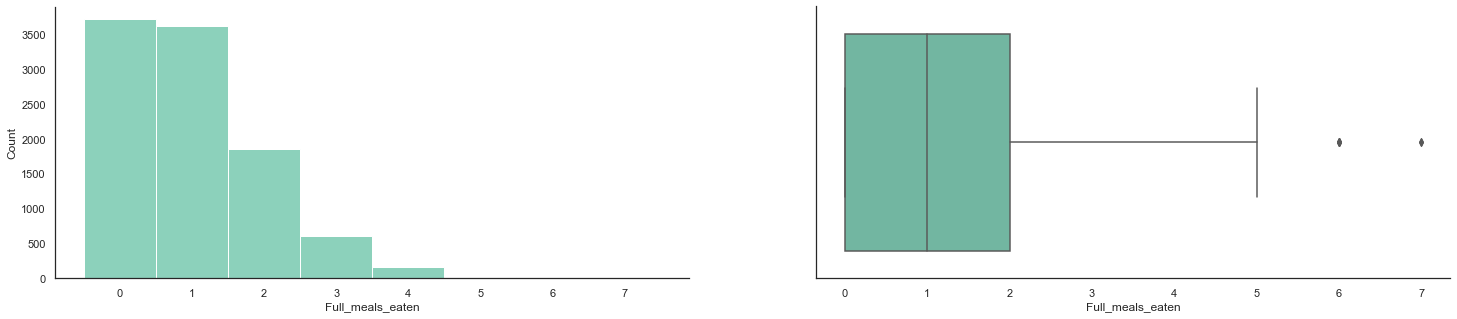

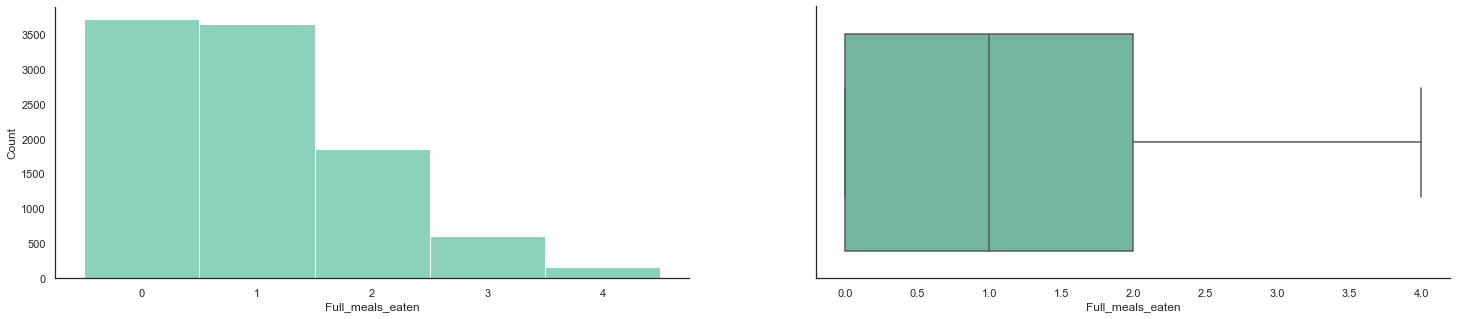

In [22]:
lib.create_hist_and_boxplots(df, "Full_meals_eaten")
lib.create_hist_and_boxplots(treated_df, "Full_meals_eaten")


### Re-Expression Categories Treatment

In [23]:
# convert categorical string values to category data type

# convert "Soft_drink" nan's to 'No'
treated_df.loc[df["Soft_drink"].isna(), "Soft_drink"] = "No"

# convert "Overweight" float64's to Yes/No bools
treated_df["Overweight"] = treated_df["Overweight"].map(
    {np.nan: "No", 0: "No", "No": "No", 1: "Yes", "Yes": "Yes"}
)

treated_df["Anxiety"] = treated_df["Anxiety"].map(
    {np.nan: "No", 0: "No", "No": "No", 1: "Yes", "Yes": "Yes"}
)

# validate a value exists for each row
assert len(treated_df["Soft_drink"].isna().index) == len(treated_df.index)

# categorical columns and potential categorical columns
ctg_cols = [
    "Anxiety",
    "Area",
    "Timezone",
    "Employment",
    "Education",
    "Marital",
    "Gender",
    "ReAdmis",
    "Soft_drink",
    "Initial_admin",
    "HighBlood",
    "Stroke",
    "Complication_risk",
    "Overweight",
    "Arthritis",
    "Diabetes",
    "Hyperlipidemia",
    "BackPain",
    "Allergic_rhinitis",
    "Reflux_esophagitis",
    "Asthma",
    "Services",
]

for col in ctg_cols:
    # print(treated_df[col].unique())
    print(f"--- COLUMN: '{col}' ---")
    # sort the unique values and print 1 value per line
    # print(*np.sort(df[col].unique()), sep='\n', end="\n\n")

    # convert column to a category
    treated_df[col] = treated_df[col].astype("category")

    # confirm the values successfully converted
    assert treated_df[col].dtype == "category"

    # report categorical counts
    print(treated_df[col].value_counts())

ctg_cols = treated_df.select_dtypes("category").columns


--- COLUMN: 'Anxiety' ---
No     7094
Yes    2906
Name: Anxiety, dtype: int64
--- COLUMN: 'Area' ---
Rural       3369
Suburban    3328
Urban       3303
Name: Area, dtype: int64
--- COLUMN: 'Timezone' ---
America/New_York                  3889
America/Chicago                   3771
America/Los_Angeles                937
America/Denver                     612
America/Detroit                    262
America/Indiana/Indianapolis       151
America/Phoenix                    100
America/Boise                       86
America/Anchorage                   50
America/Puerto_Rico                 43
Pacific/Honolulu                    34
America/Menominee                   14
America/Nome                        12
America/Indiana/Vincennes            8
America/Sitka                        6
America/Kentucky/Louisville          6
America/Toronto                      5
America/Indiana/Tell_City            3
America/Indiana/Marengo              3
America/North_Dakota/Beulah          2
America/Indiana/

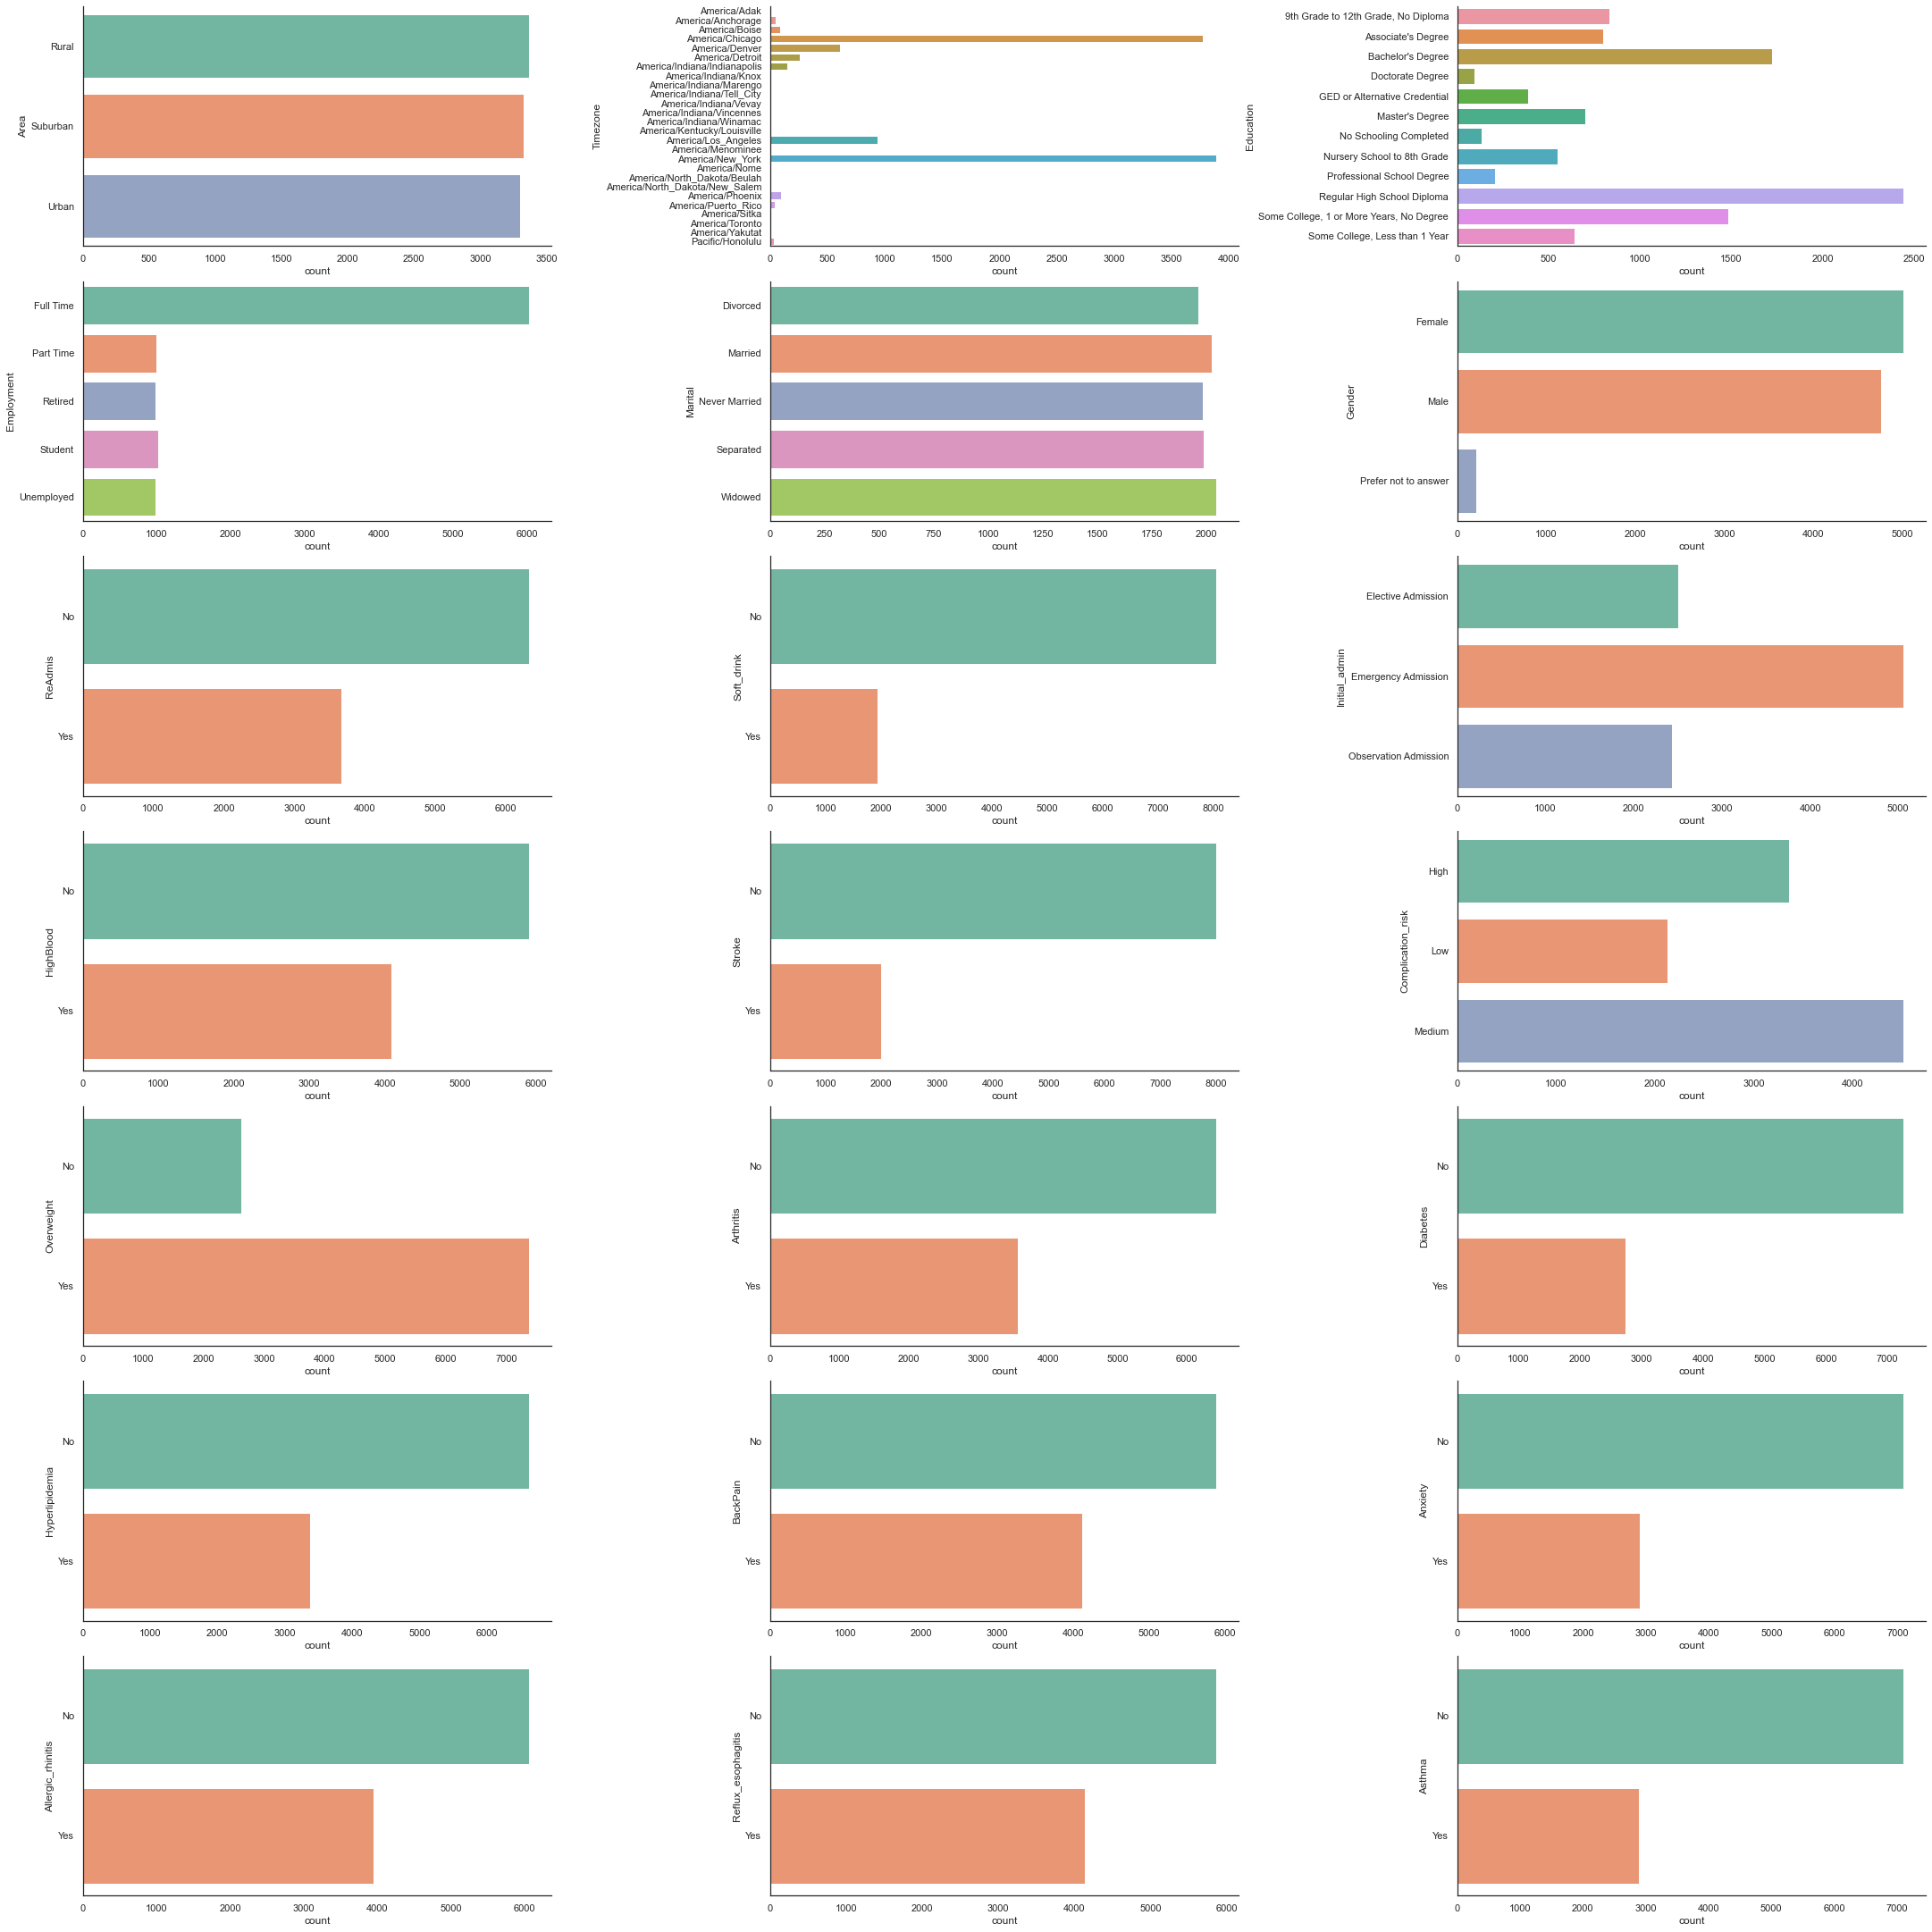

In [26]:
lib.plot_categorical_counts(treated_df, ctg_cols)


category: Area succesfully encoded
category: Timezone succesfully encoded
category: Education succesfully encoded
category: Employment succesfully encoded
category: Marital succesfully encoded
category: Gender succesfully encoded
category: ReAdmis succesfully encoded
category: Soft_drink succesfully encoded
category: Initial_admin succesfully encoded
category: HighBlood succesfully encoded
category: Stroke succesfully encoded
category: Complication_risk succesfully encoded
category: Overweight succesfully encoded
category: Arthritis succesfully encoded
category: Diabetes succesfully encoded
category: Hyperlipidemia succesfully encoded
category: BackPain succesfully encoded
category: Anxiety succesfully encoded
category: Allergic_rhinitis succesfully encoded
category: Reflux_esophagitis succesfully encoded
category: Asthma succesfully encoded
category: Services succesfully encoded


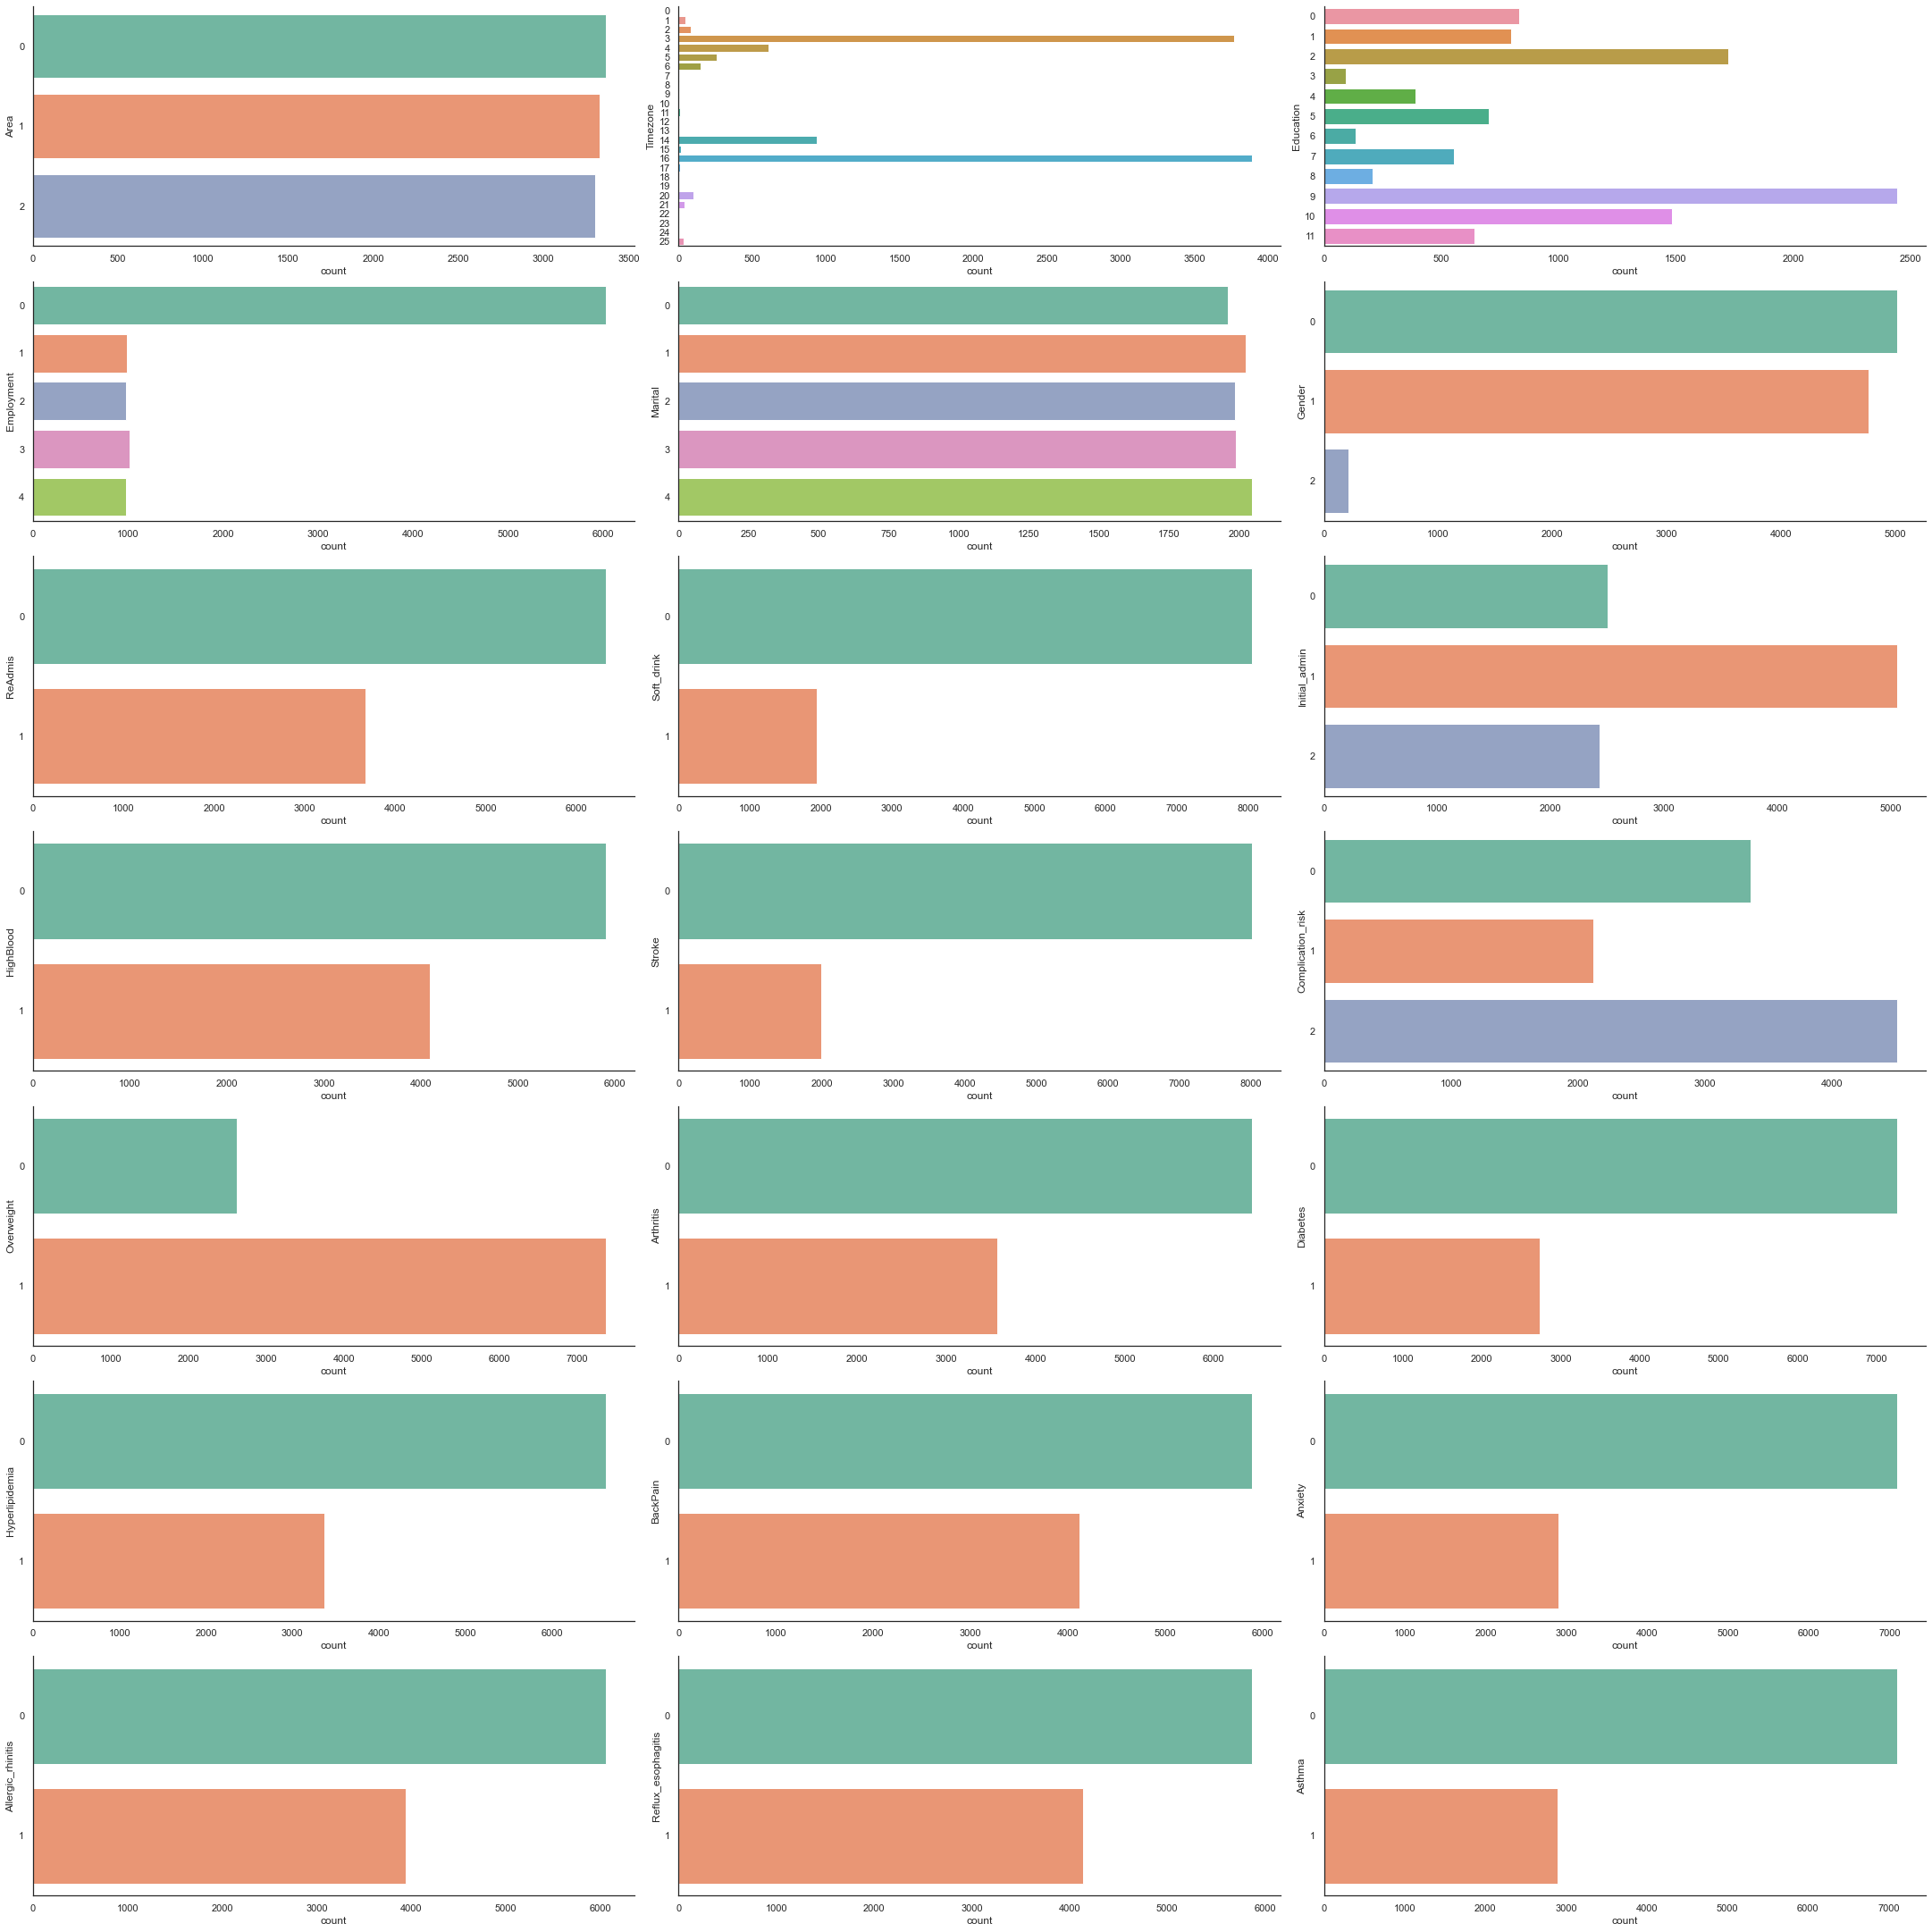

In [27]:
if treated_df.columns[treated_df.dtypes == "category"].any():
    category_df = treated_df.copy()
    encodings, encoded_df, ctg_cols = lib.create_category_encodings(category_df)
    treated_df = encoded_df
else:
    print("categories are already encoded")

# ctg_cols
lib.plot_categorical_counts(
    treated_df,
    [
        "Area",
        "Timezone",
        "Education",
        "Employment",
        "Marital",
        "Gender",
        "ReAdmis",
        "Soft_drink",
        "Initial_admin",
        "HighBlood",
        "Stroke",
        "Complication_risk",
        "Overweight",
        "Arthritis",
        "Diabetes",
        "Hyperlipidemia",
        "BackPain",
        "Anxiety",
        "Allergic_rhinitis",
        "Reflux_esophagitis",
        "Asthma",
        "Services",
    ],
)


### Other Data Cleaning Treatment

#### Drop 'Unnamed: 0' column

In [28]:
# trimwhite space from string columns
str_cols = treated_df.select_dtypes("object")
treated_df[str_cols.columns] = str_cols.apply(lambda s: s.str.strip())


In [29]:
# Verify these columns are the same, if so drop the "Unnamed: 0" column
if "Unnamed: 0" in treated_df.columns and treated_df["Unnamed: 0"].equals(
    treated_df["CaseOrder"]
):
    print("Dropping 'Unnamed: 0' column")
    treated_df = treated_df.drop(columns="Unnamed: 0", axis=1)


Dropping 'Unnamed: 0' column


#### Round Age and Children Values

In [30]:
treated_df["Age"] = treated_df["Age"].astype("int")
assert treated_df["Age"].dtype == "int"


In [31]:
treated_df["Children"] = treated_df["Children"].astype("int")
assert treated_df["Children"].dtype == "int"


## D2: Justification of Mitigation Methods

## D3: Summary of the Outcomes

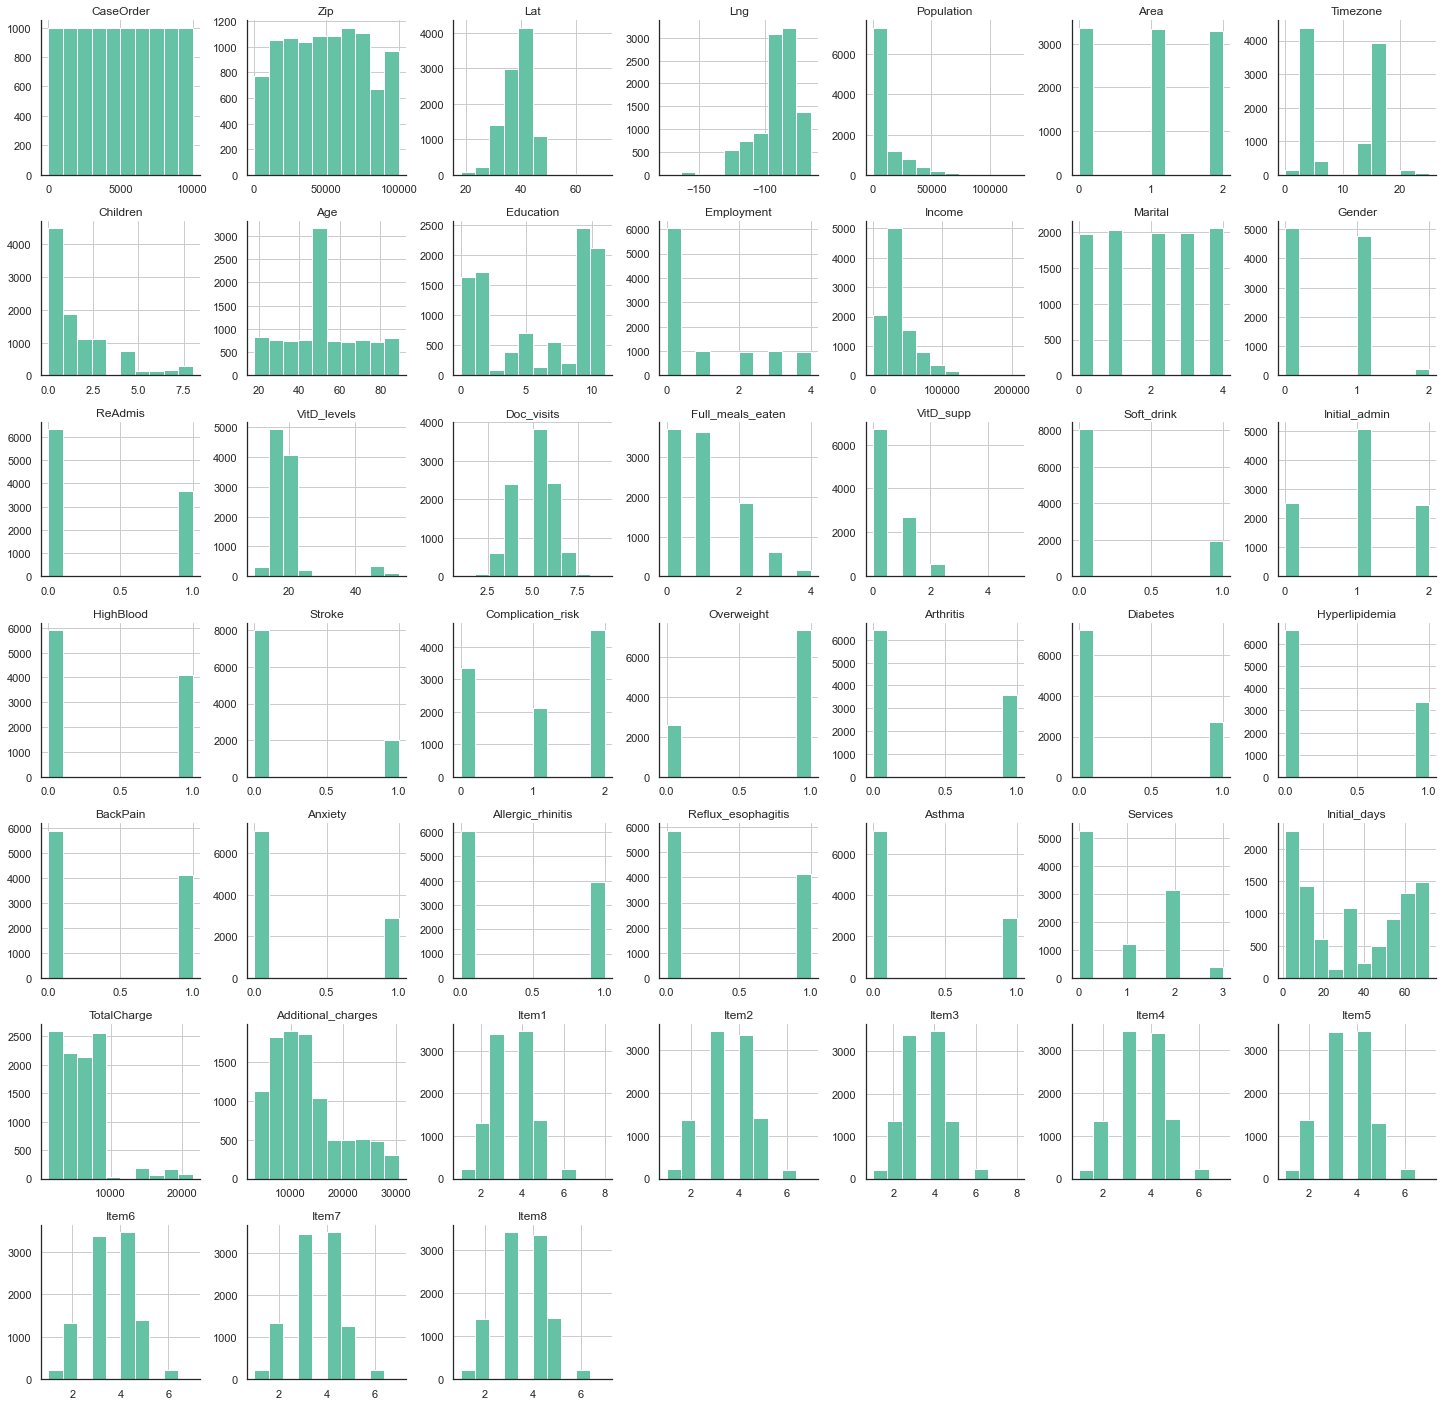

In [32]:
_ = treated_df.hist(figsize=(25, 25))


## D4: Mitigation Code 

In [33]:
treated_df.to_csv("clean_data.csv", index=False)
lib.write_encodings_csv(encodings)


In [ ]:
# example decode an encoded value by feature name and encoded value
encodings["Complication_risk"].inverse_transform([2])


## D5: Clean Data
See “clean_data.csv”.

## D6: Limitations
We treated or retained all relevant outlier and missing values. Likewise, we cast many values to more appropriate data types. Regardless, limitations exist with this approach. For example, we left several outlier values untreated because there wasn’t sufficient information or justification to replace or remove the data. Likewise, we retained outlier values that did not pertain to patient medical data. Additionally, we performed minimal validation and cross-field validation on geographic attributes. Lastly, if we add additional columns to the raw data set in the future, an analyst will need to re-evaluate and potentially treat those fields.

## D7: Impact of the Limitations
The data-cleaning limitations certainly affect the research question. The question seeks to understand what relationship(s) exists between readmitted patients and their Geographical Area type. The accuracy of the analysis depends heavily on accurate geographic data attributes. Without thoroughly cross validating these features, we risk misrepresenting the relationships between Geographical Area types and readmission. For example, conflicting Zip, Lat, Lng values that don’t align with the stated Geographical Area type lead to analysis errors. Preventing these errors requires us to perform cross-field validation against the Area feature.

## E1. Principal Components

In [34]:
pca_df = treated_df.copy()
treated_pca_df = treated_df.copy()
pca_df.describe(exclude="number")
pca_df.shape


(10000, 52)

### Correlation Heatmap

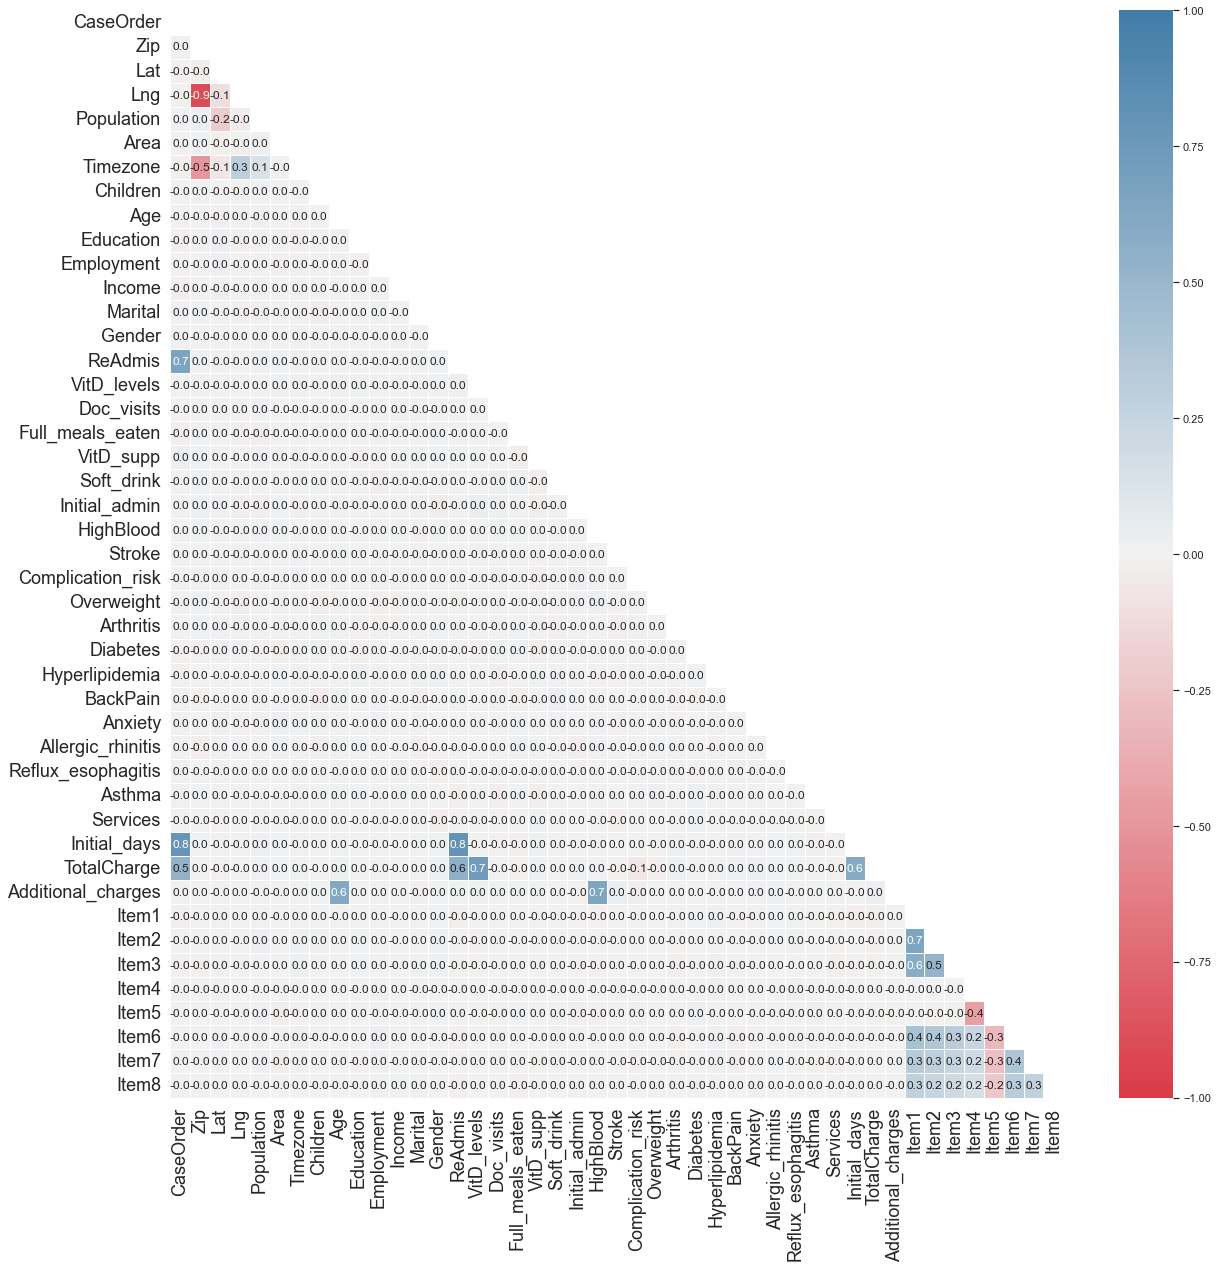

In [45]:
cmap = sns.diverging_palette(h_neg=10, h_pos=240, as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 20))
corr_df = pca_df.corr()

# mask part of the matrix
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

hm = sns.heatmap(
    corr_df,
    center=0,
    cmap=cmap,
    annot=True,
    fmt=".1f",
    vmin=-1.0,
    vmax=1.0,
    mask=mask,
    linewidths=0.5,
    ax=ax,
)

_ = hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18)
_ = hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18)


In [49]:
# store the string columns in a separate dataframe
str_cols = treated_df.select_dtypes("object")
str_cols.columns

# drop the string columns for PCA
treated_pca_df = treated_pca_df.drop(str_cols.columns, axis=1, errors="ignore")
treated_pca_df.shape


(10000, 45)

In [50]:
treated_pca_df.var().sort_values(ascending=False).head(15)


Zip                  754578276.319
Income               627141642.976
Population           219773467.972
Additional_charges    42805634.967
TotalCharge           11407898.964
CaseOrder              8334166.667
Initial_days               618.031
Age                        323.778
Lng                        231.222
VitD_levels                 45.202
Timezone                    40.508
Lat                         29.193
Education                   14.375
Children                     3.985
Marital                      2.003
dtype: float64

In [60]:
patient_features = [
    "Additional_charges",
    "Full_meals_eaten",
    "Complication_risk",
    "Children",
    "Education",
    "Doc_visits",
    "Zip",
    "Lng",
    "Lat",
    "Population",
    "Timezone",
    "Services",
    "ReAdmis",
    "Initial_admin",
    "Initial_days",
    "TotalCharge",
    "Age",
    "VitD_levels",
    "HighBlood",
    "Item1",
    "Item2",
    "Item3",
    "Item4",
    "Item5",
    "Item6",
    "Item7",
    "Item8",
]

pd.DataFrame(treated_pca_df[patient_features].var(), columns=["variance"]).sort_values("variance", ascending=False)


variance
Zip                754578276.319
Population         219773467.972
Additional_charges  42805634.967
TotalCharge         11407898.964
Initial_days             618.031
Age                      323.778
Lng                      231.222
VitD_levels               45.202
Timezone                  40.508
Lat                       29.193
Education                 14.375
Children                   3.985
Doc_visits                 1.094
Item8                      1.086
Item4                      1.074
Item2                      1.071
Item3                      1.067
Item6                      1.066
Item1                      1.065
Item5                      1.061
Item7                      1.043
Services                   0.973
Full_meals_eaten           0.954
Complication_risk          0.774
Initial_admin              0.494
HighBlood                  0.242
ReAdmis                    0.232

In [61]:
# create a dataframe using a subset of numerical features
treated_pca_feats_df = treated_pca_df[patient_features].copy()
treated_pca_feats_df

Additional_charges  Full_meals_eaten  Complication_risk  Children  \
0              17939.403                 0                  2         1   
1              17612.998                 2                  0         3   
2              17505.192                 1                  2         3   
3              12993.437                 1                  2         0   
4               3716.526                 0                  1         0   
...                  ...               ...                ...       ...   
9995            8927.642                 2                  2         0   
9996           28507.147                 0                  2         4   
9997           15281.215                 2                  0         3   
9998            7781.678                 2                  2         3   
9999           11643.190                 0                  1         8   

      Education  Doc_visits    Zip      Lng    Lat  Population  Timezone  \
0            11           6  35621  -86.725 34.350        2951         3   
1            10           4  32446  -85.229 30.845       11303         3   
2            10           4  57110  -96.638 43.543       17125         3   
3             4           4  56072  -93.515 43.897        2162         3   
4             9           5  23181  -76.890 37.599        5287        16   
...         ...         ...    ...      ...    ...         ...       ...   
9995          2           4  27563  -78.237 36.429        4762        16   
9996          9           5   8340  -74.873 39.436        1251        16   
9997          9           4  37171  -87.300 36.367         532         3   
9998          2           5  57775 -102.016 44.104         271         4   
9999          0           5  15108  -80.200 40.500       41524        16   

      Services  ReAdmis  Initial_admin  Initial_days  TotalCharge  Age  \
0            0        0              1        10.586     3191.049   53   
1            2        0              1        15.130     4214.905   51   
2            0        0              0         4.772     2177.587   53   
3            0        0              0         1.715     2465.119   78   
4            1        0              0         1.255     1885.655   22   
...        ...      ...            ...           ...          ...  ...   
9995         2        0              1        51.561     6651.241   25   
9996         1        1              0        68.668     7851.523   87   
9997         2        1              0        34.432     7725.953   53   
9998         0        1              1        63.357     8462.832   43   
9999         0        1              2        70.851     8700.856   53   

      VitD_levels  HighBlood  Item1  Item2  Item3  Item4  Item5  Item6  Item7  \
0          17.802          1      3      3      2      2      4      3      3   
1          18.995          1      3      4      3      4      4      4      3   
2          17.416          1      2      4      4      4      3      4      3   
3          17.420          0      3      5      5      3      4      5      5   
4          16.871          0      2      1      3      3      5      3      4   
...           ...        ...    ...    ...    ...    ...    ...    ...    ...   
9995       16.482          1      3      2      2      3      4      3      4   
9996       18.452          1      3      3      4      2      5      3      4   
9997       15.753          1      3      3      3      4      4      2      3   
9998       21.956          0      5      5      3      4      4      3      4   
9999       20.422          0      4      3      3      2      3      6      4   

      Item8  
0         4  
1         3  
2         3  
3         5  
4         3  
...     ...  
9995      2  
9996      4  
9997      2  
9998      3  
9999      3  

[10000 rows x 27 columns]

In [64]:
from sklearn.feature_selection import VarianceThreshold

vt_df = treated_pca_feats_df.copy()

# Feature selector that removes all low-variance features based on a variance threshold.
sel = VarianceThreshold(threshold=0.75)

sel.fit_transform(vt_df)
# sel.fit_transform(vt_df / vt_df.mean())

# boolean array of shape [# input features], where an element is True if its corresponding feature is selected for retention.
mask = sel.get_support()

# retained columns
retain_cols = vt_df.loc[:, mask].columns

# dropped columns
drop_cols = vt_df.loc[:, ~mask].columns

display(pd.DataFrame({"retained": retain_cols}))
display(pd.DataFrame({"dropped fields": drop_cols}))


retained
0   Additional_charges
1     Full_meals_eaten
2    Complication_risk
3             Children
4            Education
5           Doc_visits
6                  Zip
7                  Lng
8                  Lat
9           Population
10            Timezone
11            Services
12        Initial_days
13         TotalCharge
14                 Age
15         VitD_levels
16               Item1
17               Item2
18               Item3
19               Item4
20               Item5
21               Item6
22               Item7
23               Item8

dropped fields
0        ReAdmis
1  Initial_admin
2      HighBlood

#### Scree Plot (An optimal number of principle components)
Shows the variance explained by each factor in a factor analysis to assess the optimum number of factors to take into account.

Eigenvalues are the variance explained by each principal component, and to repeat, are constrained to decrease monotonically from the first principal component to the last. These eigenvalues are commonly
plotted on a scree plot to show the decreasing rate at which variance is explained by additional principal components

One common criteria is to ignore principal components at the point at which the next PC offers little increase in the total variance explained. A second criteria is to include all those PCs up to a predetermined total percent variance explained, such as 90%. A third standard is to ignore components whose variance explained is less than 1 when a correlation matrix is used or less than the average variance explained when a covariance matrix is used, with the idea being that such a PC offers less than one variable’s worth of information. A fourth standard is to ignore the last PCs whose variance explained is all roughly equal.

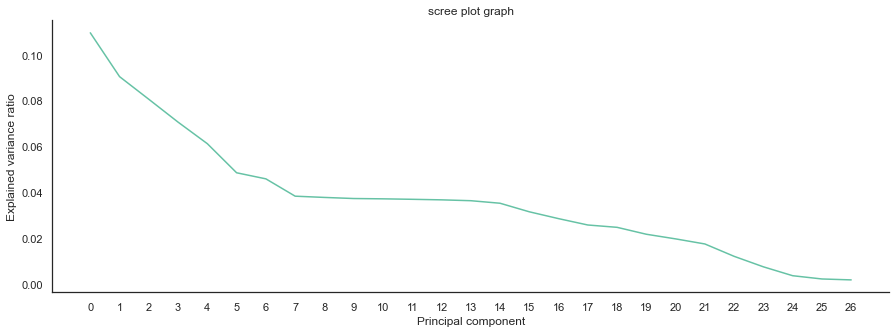

In [65]:
pipe = Pipeline([("scaler", StandardScaler()), ("reducer", PCA())])

pipe.fit(treated_pca_feats_df)
pca = pipe.steps[1][1]
num_components = len(pca.components_)
var = pipe.steps[1][1].explained_variance_ratio_

fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.set_title("scree plot graph")
sns.lineplot(data=var, ax=axs)

plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.xticks(np.arange(0, num_components, 1))

plt.show()


In [66]:
print(pca.explained_variance_ratio_.cumsum())


[0.1095833  0.20005577 0.28065083 0.35127765 0.41250352 0.46105272
 0.50695273 0.54529767 0.58309959 0.62042289 0.65761064 0.69459343
 0.73134141 0.76771408 0.80298415 0.83452275 0.86307738 0.88885767
 0.91362075 0.93536495 0.95508793 0.97259683 0.9847104  0.99224982
 0.99591596 0.99816033 1.        ]


#### Loadings Table

In [70]:
# create dataframe from principal components
# correlation coefficients between the features and the principal components
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i}" for i in range(0, num_components)],
    index=treated_pca_feats_df.columns,
)

loadings


PC0    PC1    PC2    PC3    PC4    PC5    PC6    PC7  \
Additional_charges  0.001  0.046 -0.013  0.702  0.041 -0.030 -0.008 -0.000   
Full_meals_eaten   -0.002 -0.016  0.019  0.025  0.026  0.060 -0.058 -0.096   
Complication_risk  -0.005 -0.026 -0.010 -0.017  0.022 -0.062 -0.071  0.449   
Children            0.002  0.005  0.010  0.010  0.023 -0.028  0.029  0.214   
Education           0.002  0.006  0.027  0.008  0.029  0.057 -0.046 -0.106   
Doc_visits          0.007 -0.003  0.001  0.013 -0.007  0.016  0.016  0.372   
Zip                -0.020  0.025  0.650  0.015 -0.008 -0.003  0.144 -0.004   
Lng                 0.013 -0.022 -0.614 -0.011  0.004 -0.018 -0.099 -0.009   
Lat                 0.008 -0.016  0.075 -0.005  0.010  0.089 -0.637  0.019   
Population          0.010  0.025 -0.031 -0.008  0.023 -0.094  0.702  0.065   
Timezone            0.024 -0.008 -0.434 -0.001  0.008  0.003  0.186  0.043   
Services           -0.015 -0.013  0.001  0.008 -0.005 -0.023 -0.014 -0.091   
ReAdmis            -0.047  0.524 -0.010 -0.049  0.049 -0.382 -0.071  0.029   
Initial_admin      -0.005  0.013  0.025 -0.010 -0.035  0.117 -0.060  0.669   
Initial_days       -0.047  0.533 -0.006 -0.061  0.043 -0.381 -0.070  0.013   
TotalCharge        -0.043  0.580 -0.027 -0.016 -0.008  0.322  0.026 -0.025   
Age                -0.001  0.036 -0.021  0.483  0.044 -0.020 -0.029 -0.242   
VitD_levels        -0.019  0.300 -0.030  0.012 -0.046  0.744  0.091 -0.018   
HighBlood          -0.005  0.024  0.002  0.512  0.016 -0.024  0.019  0.258   
Item1               0.454  0.023  0.017 -0.017  0.294  0.027  0.002 -0.000   
Item2               0.427  0.027  0.016 -0.016  0.293  0.003  0.011  0.015   
Item3               0.394  0.022  0.012 -0.021  0.294  0.020 -0.017 -0.018   
Item4               0.151  0.028 -0.001  0.022 -0.554 -0.052  0.008 -0.039   
Item5              -0.189 -0.035  0.003 -0.035  0.579  0.051  0.012  0.001   
Item6               0.409  0.038  0.016  0.003 -0.163 -0.006 -0.003  0.015   
Item7               0.355  0.042  0.008  0.019 -0.171 -0.022  0.001 -0.022   
Item8               0.311  0.029  0.001  0.005 -0.168 -0.005 -0.011  0.029   

                      PC8    PC9   PC10   PC11   PC12   PC13   PC14   PC15  \
Additional_charges -0.001 -0.002 -0.009 -0.009  0.005 -0.007 -0.016  0.009   
Full_meals_eaten    0.053  0.374  0.735  0.353  0.039  0.357  0.181  0.048   
Complication_risk   0.499 -0.419  0.153 -0.177  0.169  0.078  0.510 -0.081   
Children            0.215  0.111 -0.532  0.636 -0.255  0.357  0.099 -0.031   
Education          -0.078 -0.611  0.284  0.512 -0.302 -0.381 -0.100 -0.097   
Doc_visits         -0.594  0.098  0.056 -0.173 -0.525 -0.001  0.424 -0.083   
Zip                 0.017 -0.006  0.004 -0.024  0.006  0.016  0.014  0.019   
Lng                -0.005  0.029  0.001  0.004 -0.017 -0.003 -0.044 -0.272   
Lat                -0.099 -0.056 -0.109  0.048  0.035 -0.072  0.102  0.656   
Population         -0.023 -0.091  0.044  0.043 -0.005 -0.051  0.036  0.433   
Timezone            0.002 -0.043  0.033  0.040  0.020 -0.001  0.051  0.494   
Services            0.534  0.414  0.040 -0.104 -0.487 -0.517  0.095  0.075   
ReAdmis            -0.011  0.011  0.042  0.018 -0.008  0.000 -0.015  0.003   
Initial_admin       0.094  0.056  0.208 -0.060 -0.127  0.061 -0.667  0.076   
Initial_days       -0.010 -0.000  0.036  0.005 -0.007  0.000 -0.022  0.016   
TotalCharge         0.009  0.017 -0.026 -0.009  0.013 -0.011  0.031 -0.011   
Age                 0.135 -0.238  0.031 -0.265 -0.372  0.403 -0.109  0.076   
VitD_levels         0.061 -0.021 -0.050 -0.029  0.023  0.003  0.100 -0.028   
HighBlood          -0.111  0.196 -0.032  0.225  0.376 -0.382  0.099 -0.080   
Item1               0.007  0.016 -0.007 -0.006  0.001 -0.003 -0.010 -0.030   
Item2               0.013  0.006 -0.010  0.002 -0.010 -0.005 -0.012 -0.005   
Item3               0.007 -0.001  0.007 -0.009  0.009  0.008 -0.016 -0.018   
Item4               0.039 -0.034 -0.001  0.

## E2. Criteria Used
We identified the data set’s principal components by first selecting a subset of numerical data features that we pretreated to deal with missing data and outliers. We then created a separate data frame for these features. Next, we create a sklearn.pipeline.Pipeline that first standardizes the data before sending the values to a sklearn.decomposition.PCA instance. We then created and displayed a transformed data frame mapping the original feature labels with the principal components. We used this Loadings Table to understand the correlation coefficients between each feature and the principal components (Larose, C. D., & Larose, D. T., 2019). To determine the number of principal components to select, we computed the eigenvalues using our principal components and used the eigenvalues to create a scree plot. We examined this scree plot and used the Kaiser Rule to determine that we should select the first 11 principal components because their eigenvalues were greater than 1 (Larose, C. D., & Larose, D. T., 2019).

Based on the Kaiser Rule, we'll keep the first 11 PCs


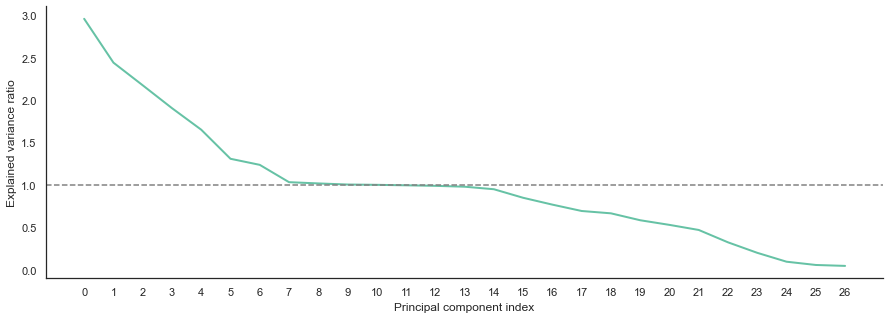

In [74]:
test_pca_normalized = StandardScaler().fit_transform(treated_pca_feats_df)

cov_matrix = np.dot(
    test_pca_normalized.T, test_pca_normalized / treated_pca_feats_df.shape[0]
)

# Eigenvalues are the variance explained by each principal component and are constrained to decrease monotonically from the first principal component to the last
eigenvalues = [
    np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector))
    for eigenvector in pca.components_
]

plt.figure(figsize=(15, 5))

plt.plot(eigenvalues, linewidth=2)
plt.xticks(np.arange(0, treated_pca_feats_df.shape[1], 1))
plt.axhline(y=1, color="gray", linestyle="--")
plt.xlabel("Principal component index")
plt.ylabel("Explained variance ratio")

treated_pca_feats_df.shape[1]
cs = pca.explained_variance_ratio_.cumsum()
evs = np.array(eigenvalues)
num_pcs_to_use = len(evs[evs >= 1])

# The Kaiser rule: drop all components with eigenvalues < 1.0
print(f"Based on the Kaiser Rule, we'll keep the first {num_pcs_to_use} PCs")


## E3. Benefits
Principal Component Analysis (PCA) can benefit an organization by objectively and statistically reducing the dimensionality of large data set. What this leads to is “the best way to group variables so that the new groupings give basically the same information as the individual variables” (Larose, C. D., & Larose, D. T., 2019). This is helpful in reducing redundant information and allows quicker data exploration and analysis — not to mention machine learning processes will complete quicker when using less data. Lastly this is beneficial because it identifies data features that explain covariation.

# Part IV. Supporting Documents
---

## F. Video

## G. Web Sources

1.	https://datascience.stackexchange.com/questions/60955/how-to-check-all-values-in-particular-column-has-same-data-type-or-not
2.	https://datatofish.com/check-nan-pandas-dataframe/
3.	https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.zscore.html
4.	https://github.com/ResidentMario/missingno
5.	https://matplotlib.org/stable
6.	https://michael-fuchs-python.netlify.app/2019/04/28/how-to-suppress-scientific-notation-in-pandas/
7.	https://numpy.org/doc/stable/reference/generated/numpy.all.html
8.	https://pandas.pydata.org/docs/
9.	https://scikit-learn.org/stable/modules/classes.html
10.	https://seaborn.pydata.org/
11.	https://stackabuse.com/change-tick-frequency-in-matplotlib/
12.	https://stackoverflow.com/a/53585379
13.	https://stackoverflow.com/a/57649212
14.	https://stackoverflow.com/q/47139203
15.	https://stackoverflow.com/questions/12608788/changing-the-tick-frequency-on-x-or-y-axis-in-matplotlib
16.	https://stackoverflow.com/questions/15891038/change-column-type-in-pandas
17.	https://stackoverflow.com/questions/22391433/count-the-frequency-that-a-value-occurs-in-a-dataframe-column
18.	https://stackoverflow.com/questions/31029560/plotting-categorical-data-with-pandas-and-matplotlib
19.	https://stackoverflow.com/questions/34301088/reading-writing-out-a-dictionary-to-csv-file-in-python/34301228
20.	https://stackoverflow.com/questions/37366717/pandas-print-column-name-with-missing-values
21.	https://stackoverflow.com/questions/37968730/set-index-name-of-pandas-dataframe
22.	https://stackoverflow.com/questions/38876816/change-value-of-a-dataframe-column-based-on-a-filter
23.	https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
24.	https://stackoverflow.com/questions/40339886/pandas-concat-generates-nan-values
25.	https://stackoverflow.com/questions/40950310/strip-trim-all-strings-of-a-dataframe
26.	https://stackoverflow.com/questions/43392588/how-to-increase-the-figure-size-of-dataframe-hist-for-pandas-0-11-0
27.	https://stackoverflow.com/questions/47139203/transpose-pandas-dataframe-and-change-the-column-headers-to-a-list
28.	https://stackoverflow.com/questions/48198021/filter-pandas-dataframe-with-specific-column-names-in-python
29.	https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009
30.	https://www.geeksforgeeks.org/creating-horizontal-bar-charts-using-pandas/
31.	https://www.geeksforgeeks.org/get-list-of-column-headers-from-a-pandas-dataframe/
32.	https://www.kite.com/python/answers/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python


## H. Sources/References

Ingargiola, A., & contributors. (2015). What is the Jupyter Notebook. 1. What is the Jupyter Notebook? - Jupyter/IPython Notebook Quick Start Guide 0.1 documentation. Retrieved February 15, 2022, from https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html 

Larose, C. D., & Larose, D. T. (2019). Data science using Python and R. ISBN-13: 978-1-119-52684-1. 

Pandas. Pandas Documentation - pandas 1.4.1 documentation. (2022). Retrieved February 10, 2022, from https://pandas.pydata.org/docs/index.html 

scikit-learn developers. (2021). Getting started. Getting Started — scikit-learn 1.0.2 documentation. Retrieved February 15, 2022, from https://scikit-learn.org/stable/getting_started.html 

SciPy developers. (2022). Numpy and Scipy Documentation. Numpy and Scipy Documentation - Numpy and Scipy documentation. Retrieved February 15, 2022, from https://docs.scipy.org/doc/  
